In [3]:
%pip install -q numpy pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [39]:
import json
import os
import re
import glob
from collections import defaultdict
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================================
# Funções reutilizáveis: passe o diretório da aplicação
#
# Convenção nova (preferencial):
#   app_dir/
#     out/total.out                  (tempos reais)
#     total.json                     (argumentos/entradas)
#     10.json, 20.json, 37.json...   (estimativas por %)
#
# Compatibilidade com a convenção antiga (multi-paramount):
#   app_dir/mult-pascal-sscad-teste2.json           (total)
#   app_dir/mult-paramount10-sscad.json, ...        (parciais)
#   app_dir/out/total.out OU raytrace/slurm/total.out
# ==========================================================

def extract_first_number(text: str) -> int:
    m = re.search(r"\d+", str(text))
    return int(m.group(0)) if m else 0


def first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    tried = "\n".join(f" - {p}" for p in paths if p)
    raise FileNotFoundError(f"Nenhum arquivo encontrado. Tentei:\n{tried}")


def parse_total_out(total_out_path: str):
    """
    Parseia o total.out no formato:
      "Cores: 128 Input: 0"
      "Total time 0.027245283126831055"
    Retorna:
      cores_list (desc) e real_times_map[input_idx] = [t_core128, t_core64, ...]
    onde cada tempo é a média das repetições no log.
    """
    with open(total_out_path, "r") as f:
        lines = f.readlines()

    data = defaultdict(list)  # (cores, input) -> [t1, t2, ...]
    current = None

    re_header = re.compile(r"Cores:\s*(\d+)\s+Input:\s*(\d+)")
    re_time = re.compile(r"Total time\s*([0-9\.]+)")

    for line in lines:
        m = re_header.search(line)
        if m:
            cores = int(m.group(1))
            inp = int(m.group(2))
            current = (cores, inp)
            continue

        m2 = re_time.search(line)
        if m2 and current is not None:
            data[current].append(float(m2.group(1)))

    if not data:
        raise ValueError(
            f"Parse vazio em {total_out_path}. Verifique se o arquivo contém linhas 'Cores:' e 'Total time'."
        )

    means = {}  # (cores, input) -> mean_time
    for key, times in data.items():
        means[key] = float(sum(times) / len(times))

    grouped_by_input = defaultdict(dict)  # input -> {cores: mean_time}
    cores_set = set()
    for (cores, inp), mean_time in means.items():
        grouped_by_input[inp][cores] = mean_time
        cores_set.add(cores)

    cores_list = sorted(cores_set, reverse=True)
    real_times_map = {}
    for inp in sorted(grouped_by_input.keys()):
        times_by_core = grouped_by_input[inp]
        real_times_map[inp] = [times_by_core.get(c, np.nan) for c in cores_list]

    return cores_list, real_times_map


def extract_times_by_input(data: dict, input_idx: int):
    """
    Retorna dict {cores: tempo_estimado_em_segundos} para um input_idx, usando:
      tempo = max(stop_time das regiões) - start_time
    """
    times = {}
    pattern = re.compile(rf"^(\d+);{input_idx};1$")

    for key, entry in data.get("data", {}).items():
        m = pattern.match(key)
        if not m:
            continue

        ncores = int(m.group(1))
        start = entry.get("start_time")
        regions_dict = entry.get("regions", {})
        if start is None or not regions_dict:
            times[ncores] = np.nan
            continue

        try:
            max_stop = max(
                stop
                for regions in regions_dict.values()
                for (_, stop, *_) in regions
            )
            times[ncores] = float(max_stop - start)
        except Exception:
            times[ncores] = np.nan

    return times


def _percent_label_from_path(path: str) -> str:
    base = os.path.basename(path)
    stem, _ext = os.path.splitext(base)
    # novo padrão: 10.json -> 10%
    if stem.isdigit():
        return f"{int(stem)}%"
    # antigo padrão: mult-paramount10-sscad.json -> 10%
    m = re.search(r"mult-paramount(\d+)", base)
    if m:
        return f"{m.group(1)}%"
    # fallback
    return stem


def _percent_value(label: str) -> int:
    return extract_first_number(label)


def _find_total_json(app_dir: str) -> str:
    candidates = [
        os.path.join(app_dir, "total.json"),
        os.path.join(app_dir, "mult-pascal-sscad-teste2.json"),
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    # fallback: qualquer json com 'total' no nome
    for p in sorted(glob.glob(os.path.join(app_dir, "*total*.json"))):
        return p
    raise FileNotFoundError(
        f"Não encontrei o JSON total em {app_dir}. Esperado: total.json (novo) ou mult-pascal-sscad-teste2.json (antigo)."
    )


def _find_partial_jsons(app_dir: str, total_json_path: str) -> List[Tuple[str, str]]:
    """Retorna lista de tuplas (path, label)."""
    # novo: 10.json, 20.json, ...
    all_json = [p for p in glob.glob(os.path.join(app_dir, "*.json"))]
    all_json = [p for p in all_json if os.path.abspath(p) != os.path.abspath(total_json_path)]
    numeric = [p for p in all_json if os.path.splitext(os.path.basename(p))[0].isdigit()]
    if numeric:
        numeric = sorted(numeric, key=lambda p: extract_first_number(os.path.basename(p)))
        return [(p, _percent_label_from_path(p)) for p in numeric]

    # antigo: mult-paramount*-sscad.json
    old = glob.glob(os.path.join(app_dir, "mult-paramount*-sscad.json"))
    old = sorted(old, key=lambda p: extract_first_number(os.path.basename(p)))
    if old:
        return [(p, _percent_label_from_path(p)) for p in old]

    raise FileNotFoundError(
        f"Não encontrei JSONs parciais em {app_dir}. Esperado novo (10.json/20.json/...) ou antigo (mult-paramount*-sscad.json)."
    )


def _find_total_out(app_dir: str) -> str:
    candidates = [
        os.path.join(app_dir, "out", "total.out"),
        os.path.join(app_dir, "out", "total"),  # caso sem extensão
        os.path.join("raytrace", "slurm", "total.out"),  # legado do seu workspace
    ]
    try:
        return first_existing(candidates)
    except FileNotFoundError:
        # fallback: primeiro arquivo com 'total' dentro de app_dir/out
        out_dir = os.path.join(app_dir, "out")
        if os.path.isdir(out_dir):
            for p in sorted(glob.glob(os.path.join(out_dir, "*total*"))):
                return p
        raise


def build_error_dataset(app_dir: str):
    """
    Constrói df_errors (formato longo) e devolve também cores_list (desc).
    Colunas df_errors: Paramount, Núcleos, Entrada, Erro Relativo (%)
    """
    app_dir = os.path.abspath(app_dir)
    total_out_path = _find_total_out(app_dir)
    total_json_path = _find_total_json(app_dir)
    partials = _find_partial_jsons(app_dir, total_json_path)

    cores_list, real_times_map = parse_total_out(total_out_path)

    with open(total_json_path, "r") as f:
        total_data = json.load(f)

    arguments = total_data.get("config", {}).get("arguments", [])
    arg_labels = [os.path.basename(arg) for arg in arguments]
    sorted_arg_labels = sorted(arg_labels, key=extract_first_number)
    arg_label_to_idx = {label: i for i, label in enumerate(arg_labels)}

    error_rows = []
    for json_path, percentage_label in partials:
        with open(json_path, "r") as f:
            partial_data = json.load(f)

        for arg_label in sorted_arg_labels:
            input_idx = arg_label_to_idx.get(arg_label)
            if input_idx is None:
                continue

            real_times = real_times_map.get(input_idx)
            if real_times is None:
                continue

            est_by_core = extract_times_by_input(partial_data, input_idx)
            est_times = [est_by_core.get(c, np.nan) for c in cores_list]

            for ncores, r, e in zip(cores_list, real_times, est_times):
                if pd.isna(r) or r <= 0 or pd.isna(e):
                    err = np.nan
                else:
                    err = (abs(r - e) / r) * 100.0

                error_rows.append(
                    {
                        "Paramount": percentage_label,
                        "Núcleos": int(ncores),
                        "Entrada": extract_first_number(arg_label),
                        "Erro Relativo (%)": err,
                    }
                )

    df_errors = pd.DataFrame(error_rows)
    if df_errors.empty:
        raise ValueError(
            "df_errors ficou vazio: não foi possível casar total.out com os JSONs parciais/total."
        )

    paramount_order = sorted(df_errors["Paramount"].dropna().unique(), key=_percent_value)
    df_errors["Paramount"] = pd.Categorical(df_errors["Paramount"], categories=paramount_order, ordered=True)
    df_errors["Entrada"] = pd.to_numeric(df_errors["Entrada"], errors="coerce")

    print(f"APP: {app_dir}")
    print(f"total.out: {total_out_path}")
    print(f"total.json: {total_json_path}")
    print(f"parciais: {[os.path.basename(p) for p,_ in partials]}")
    print(f"df_errors: {len(df_errors)} linhas | {df_errors['Paramount'].nunique()} porcentagens")

    return df_errors, cores_list


def plot_error_heatmaps(df_errors: pd.DataFrame, vmax: float = 100.0):
    for pct in df_errors["Paramount"].cat.categories:
        sub = df_errors[df_errors["Paramount"] == pct]
        heatmap_df = (
            sub.pivot(index="Núcleos", columns="Entrada", values="Erro Relativo (%)")
            .sort_index(ascending=False)
        )
        if heatmap_df.empty:
            continue

        annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            heatmap_df,
            annot=annot,
            fmt="",
            cmap="coolwarm",
            cbar_kws={"label": "Absolute Relative Error (%)"},
            vmin=0,
            vmax=vmax,
            annot_kws={"size": 12},
            mask=heatmap_df.isna(),
        )
        plt.title(f"Paramount: {pct}")
        plt.xlabel("Tamanho da Entrada (Problema)")
        plt.ylabel("Número de Cores")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


def plot_error_lines_by_input(df_errors: pd.DataFrame, limiar: float = 5.0, save_path: Optional[str] = None):
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({"font.family": "sans-serif", "font.size": 11})

    df = df_errors.copy()
    df = df.dropna(subset=["Erro Relativo (%)", "Entrada", "Núcleos"])
    inputs = sorted(df["Entrada"].unique())

    g = sns.relplot(
        data=df,
        x="Núcleos",
        y="Erro Relativo (%)",
        hue="Paramount",
        col="Entrada",
        col_order=inputs,
        col_wrap=len(inputs),
        kind="line",
        style="Paramount",
        markers=True,
        dashes=False,
        height=4,
        aspect=1,
        palette="viridis_r",
        linewidth=2,
        facet_kws={"sharex": True, "sharey": True},
    )

    g.set(xscale="log", yscale="log")

    ticks_nucleos = [1, 2, 4, 8, 16, 32, 64, 128]
    for ax in g.axes.flatten():
        ax.set_xticks(ticks_nucleos)
        ax.set_xticklabels(ticks_nucleos)
        ax.grid(True, which="minor", axis="x", linestyle=":", alpha=0.4)
        ax.axhline(y=limiar, color="red", linestyle="--", linewidth=1.5, alpha=0.8)

    g.fig.subplots_adjust(top=0.9)
    g.set_axis_labels("Quantidade de Cores", "Erro Relativo %")
    g.axes.flatten()[0].text(1, limiar * 1.2, f"Limiar ({limiar}%)", color="red", fontsize=9)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


def plot_error_lines_by_paramount(
    df_errors: pd.DataFrame,
    limiar: float = 5.0,
    save_path: Optional[str] = None
):
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({"font.family": "sans-serif", "font.size": 11})

    df = df_errors.copy()
    df = df.dropna(subset=["Erro Relativo (%)", "Entrada", "Núcleos"])

    entradas = sorted(df["Entrada"].unique())

    g = sns.relplot(
        data=df,
        x="Núcleos",
        y="Erro Relativo (%)",
        hue="Entrada",          # cor por entrada
        style="Entrada",        # marcador por entrada  ← 🔑
        markers=True,           # ativa marcadores diferentes
        dashes=False,           # evita confusão visual
        col="Paramount",        # subgráficos = porcentagens
        col_order=df["Paramount"].cat.categories,
        kind="line",
        height=4,
        aspect=1,
        linewidth=2,
        palette="viridis",
        facet_kws={"sharex": True, "sharey": True},
    )

    # Escalas log
    g.set(xscale="log", yscale="log")

    ticks_nucleos = [1, 2, 4, 8, 16, 32, 64, 128]
    for ax in g.axes.flatten():
        ax.set_xticks(ticks_nucleos)
        ax.set_xticklabels(ticks_nucleos)
        ax.grid(True, which="minor", axis="x", linestyle=":", alpha=0.4)
        ax.axhline(y=limiar, color="red", linestyle="--", linewidth=1.2, alpha=0.8)

    g.set_axis_labels("Quantidade de Cores", "Erro Relativo (%)")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle("Erro Relativo por Entrada — Facet por Paramount")

    g._legend.set_title("Entrada")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    plt.show()


def plot_error_lines_by_paramount_thesis(
    df_errors,
    limiar: float = 5.0,
    save_path: Optional[str] = None,
    dpi: int = 300
):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 12,
        "axes.titlesize": 11,
        "axes.labelsize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "savefig.dpi": dpi,
    })

    df = df_errors.copy()
    df = df.dropna(subset=["Erro Relativo (%)", "Entrada", "Núcleos", "Paramount"])

    entradas = sorted(df["Entrada"].unique())

    # marcadores por Entrada (independente de cor)
    base_markers = ["o", "s", "^", "D", "X", "P", "v", "*", "<", ">", "h", "8"]
    markers_map = {e: base_markers[i % len(base_markers)] for i, e in enumerate(entradas)}

    # cores distintas por Entrada (boa para acessibilidade)
    palette = sns.color_palette("colorblind", n_colors=len(entradas))
    palette_map = {e: palette[i] for i, e in enumerate(entradas)}

    g = sns.relplot(
        data=df,
        x="Núcleos",
        y="Erro Relativo (%)",
        col="Paramount",
        col_order=df["Paramount"].cat.categories,
        col_wrap=2,                 # ✅ 2x2 em vez de 1x4 (melhora MUITO)
        hue="Entrada",
        style="Entrada",
        markers=markers_map,
        palette=palette_map,
        dashes=False,
        kind="line",
        linewidth=2.0,
        height=3.6,                 # ✅ mais alto
        aspect=1.35,                # ✅ mais largo sem ficar “fino”
        facet_kws={"sharex": True, "sharey": True},
        legend=True
    )

    g.set(xscale="log", yscale="log")
    ticks_nucleos = [1, 2, 4, 8, 16, 32, 64, 128]

    for ax in g.axes.flatten():
        ax.set_xticks(ticks_nucleos)
        ax.set_xticklabels([str(t) for t in ticks_nucleos])

        ax.grid(True, which="major", axis="both", linestyle="-", alpha=0.30)
        ax.grid(True, which="minor", axis="x", linestyle=":", alpha=0.25)

        # linha do limiar
        ax.axhline(y=limiar, color="red", linestyle="--", linewidth=1.2, alpha=0.9)

        # ✅ texto do limiar dentro do eixo (posicionamento consistente)
        ax.annotate(
            f"Limiar ({limiar:.0f}%)",
            xy=(0.02, limiar),
            xycoords=("axes fraction", "data"),
            xytext=(0, 4),
            textcoords="offset points",
            color="red",
            ha="left",
            va="bottom",
            fontsize=10
        )

    g.set_axis_labels("Quantidade de Cores", "Erro Relativo (%)")
    #g.fig.suptitle("Erro Relativo por Entrada — Facet por Paramount", y=0.98)

    # ✅ Reserva espaço e afasta legenda do último subplot
    g.fig.subplots_adjust(top=0.88, right=0.82, wspace=0.18, hspace=0.28)

    # ✅ legenda fora, centralizada verticalmente
    if g._legend is not None:
        g._legend.set_title("Entrada")
        g._legend.set_bbox_to_anchor((0.86, 0.5))  # dentro da área reservada (right=0.82)
        g._legend._loc = 6  # center left

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)

    plt.show()


def generate_graphs(app_dir: str, limiar: float = 5.0, vmax: float = 100.0, save_prefix: Optional[str] = None) -> pd.DataFrame:
    df_errors, _cores = build_error_dataset(app_dir)
    plot_error_heatmaps(df_errors, vmax=vmax)
    plot_error_lines_by_input(
        df_errors,
        limiar=limiar,
        save_path=(f"{save_prefix}_grafico_por_entrada.png" if save_prefix else None),
    )
    plot_error_lines_by_paramount(
        df_errors,
        limiar=limiar,
        save_path=(f"{save_prefix}_grafico_por_paramount.png" if save_prefix else None),
    )
    plot_error_lines_by_paramount_thesis(
        df_errors,
        limiar=limiar,
        save_path=(f"{save_prefix}_grafico_por_paramount_tese.png" if save_prefix else None),
    )
    return df_errors

In [44]:
# ==========================================================
# Ganho/Economia a partir dos .out (10/20/37/50 vs total)
#
# Interpretação (igual ao seu gráfico manual):
#   Ganho(%) = (1 - T_paramount / T_total) * 100
#   > 0  => economiza tempo
#   < 0  => fica mais lento que o total
# ==========================================================

def _parse_out_means(out_path: str):
    """Retorna dict {(cores, input_idx): mean_total_time} a partir de um .out."""
    with open(out_path, "r") as f:
        lines = f.readlines()

    data = defaultdict(list)
    current = None

    re_header = re.compile(r"Cores:\s*(\d+)\s+Input:\s*(\d+)")
    re_time = re.compile(r"Total time\s*([0-9\.]+)")

    for line in lines:
        m = re_header.search(line)
        if m:
            cores = int(m.group(1))
            inp = int(m.group(2))
            current = (cores, inp)
            continue

        m2 = re_time.search(line)
        if m2 and current is not None:
            data[current].append(float(m2.group(1)))

    means = {}
    for key, times in data.items():
        means[key] = float(sum(times) / len(times))
    return means


def _find_gain_out_files(app_dir: str) -> Tuple[str, List[Tuple[str, str]]]:
    """
    Procura baseline (total) e parciais (10/20/37/50) em app_dir/out/.
    Retorna: (total_out_path, [(pct_out_path, 'Paramount 10%'), ...])
    """
    app_dir = os.path.abspath(app_dir)
    out_dir = os.path.join(app_dir, "out")
    if not os.path.isdir(out_dir):
        raise FileNotFoundError(f"Não encontrei a pasta de logs: {out_dir}")

    # baseline
    total_out_path = first_existing(
        [
            os.path.join(out_dir, "total.out"),
            os.path.join(out_dir, "total"),
        ]
    )

    # parciais numéricos
    candidates = []
    # com extensão
    candidates.extend(glob.glob(os.path.join(out_dir, "*.out")))
    # sem extensão (10,20,37,50)
    candidates.extend([p for p in glob.glob(os.path.join(out_dir, "*")) if os.path.isfile(p)])

    partials = []
    seen = set()
    for p in candidates:
        base = os.path.basename(p)
        stem, ext = os.path.splitext(base)
        if p == total_out_path:
            continue
        if stem.isdigit():
            n = int(stem)
            label = f"Paramount {n}%"
            key = (n, os.path.abspath(p))
            if key in seen:
                continue
            seen.add(key)
            partials.append((p, label))

    partials.sort(key=lambda t: extract_first_number(t[1]))
    if not partials:
        raise FileNotFoundError(
            f"Não encontrei logs parciais numéricos em {out_dir}. Esperado: 10.out/20.out/... (ou sem extensão)."
        )

    return total_out_path, partials


def build_gain_dataset_from_outs(app_dir: str) -> pd.DataFrame:
    """
    Monta df_gain com colunas: Paramount, Núcleos, Entrada, Ganho (%).
    """
    app_dir = os.path.abspath(app_dir)
    total_json_path = _find_total_json(app_dir)
    total_out_path, partial_outs = _find_gain_out_files(app_dir)

    # Mapa input_idx -> Entrada (tamanho)
    with open(total_json_path, "r") as f:
        total_data = json.load(f)
    arguments = total_data.get("config", {}).get("arguments", [])
    arg_labels = [os.path.basename(arg) for arg in arguments]
    arg_label_to_idx = {label: i for i, label in enumerate(arg_labels)}
    # ordena por tamanho pra ficar consistente
    sorted_arg_labels = sorted(arg_labels, key=extract_first_number)

    base_means = _parse_out_means(total_out_path)
    if not base_means:
        raise ValueError(f"total.out sem dados parseáveis: {total_out_path}")

    gain_rows = []
    for out_path, pct_label in partial_outs:
        pct_means = _parse_out_means(out_path)
        if not pct_means:
            print(f"Aviso: {out_path} sem dados parseáveis. Pulando.")
            continue

        for arg_label in sorted_arg_labels:
            input_idx = arg_label_to_idx.get(arg_label)
            if input_idx is None:
                continue
            entrada = extract_first_number(arg_label)

            # pega todos os cores presentes no baseline para esse input
            cores_for_input = sorted(
                {cores for (cores, inp) in base_means.keys() if inp == input_idx},
                reverse=True,
            )
            for ncores in cores_for_input:
                t_total = base_means.get((ncores, input_idx), np.nan)
                t_pct = pct_means.get((ncores, input_idx), np.nan)
                if pd.isna(t_total) or t_total <= 0 or pd.isna(t_pct):
                    gain = np.nan
                else:
                    gain = (1.0 - (t_pct / t_total)) * 100.0

                gain_rows.append(
                    {
                        "Paramount": pct_label,
                        "Núcleos": int(ncores),
                        "Entrada": int(entrada),
                        "Ganho (%)": gain,
                    }
                )

    df_gain = pd.DataFrame(gain_rows)
    if df_gain.empty:
        raise ValueError("df_gain ficou vazio: não foi possível casar os .out parciais com o total.")

    # ordena categorias de Paramount (10, 20, 37, 50, ...)
    order = sorted(df_gain["Paramount"].dropna().unique(), key=extract_first_number)
    df_gain["Paramount"] = pd.Categorical(df_gain["Paramount"], categories=order, ordered=True)
    return df_gain


def plot_gain_bars_aggregated(df_gain: pd.DataFrame, save_path: Optional[str] = None):
    """
    Replica o seu gráfico antigo: barras com média por entrada e desvio padrão entre núcleos.
    """
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({"font.family": "sans-serif", "font.size": 12})

    df = df_gain.dropna(subset=["Ganho (%)", "Entrada", "Núcleos"]).copy()
    if df.empty:
        raise ValueError("df_gain não tem dados válidos para plotar (tudo NaN?).")

    plt.figure(figsize=(10, 6))

    # seaborn >= 0.12 usa errorbar; versões antigas usam ci
    barplot_kwargs = dict(
        data=df,
        x="Entrada",
        y="Ganho (%)",
        hue="Paramount",
        palette="viridis_r",
        alpha=0.9,
        edgecolor="black",
        capsize=0.1,
    )
    try:
        ax = sns.barplot(**barplot_kwargs, errorbar="sd")
    except TypeError:
        ax = sns.barplot(**barplot_kwargs, ci="sd")

    plt.axhline(0, color="black", linestyle="--", linewidth=1)

    plt.title("Média de Economia de Tempo por Tamanho de Entrada", fontsize=14, pad=20)
    plt.xlabel("Tamanho da Entrada (Matriz)", fontsize=12)
    plt.ylabel("Economia de Tempo Média (%)", fontsize=12)
    plt.legend(title="Configuração", loc="upper left", bbox_to_anchor=(1, 1))
    plt.ylim(bottom=-20, top=100)

    # anotação no canto inferior direito (similar ao seu x=4.6)
    entradas = sorted(df["Entrada"].unique())
    x_annot = max(0.0, len(entradas) - 0.4)
    plt.text(
        x_annot,
        -15,
        "*Barras verticais indicam\no desvio padrão entre\ndiferentes qtds de núcleos.",
        fontsize=9,
        style="italic",
        ha="left",
    )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_gain_bars_aggregated_thesis(
    df_gain: pd.DataFrame,
    save_path: Optional[str] = None,
    dpi: int = 300
):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    # --- Estilo acadêmico ---
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "font.family": "serif",      # típico em dissertação
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "axes.linewidth": 0.9,
        "grid.linewidth": 0.6,
        "savefig.dpi": dpi,
    })

    df = df_gain.dropna(subset=["Ganho (%)", "Entrada", "Núcleos", "Paramount"]).copy()
    if df.empty:
        raise ValueError("df_gain não tem dados válidos para plotar (tudo NaN?).")

    # Ordena entradas (x) e categorias (hue) para consistência visual
    entradas = sorted(df["Entrada"].unique())
    df["Entrada"] = pd.Categorical(df["Entrada"], categories=entradas, ordered=True)

    if not isinstance(df["Paramount"].dtype, pd.CategoricalDtype):
        order = sorted(df["Paramount"].unique(), key=extract_first_number)
        df["Paramount"] = pd.Categorical(df["Paramount"], categories=order, ordered=True)
    hue_order = list(df["Paramount"].cat.categories)

    # Paleta colorblind-friendly (boa para dissertação)
    palette = sns.color_palette("colorblind", n_colors=len(hue_order))

    fig, ax = plt.subplots(figsize=(10.5, 6.2))

    # Força grid horizontal visível (estilo dissertação)
    ax.set_axisbelow(True)  # grid atrás das barras, mas visível

    ax.yaxis.grid(
        True,
        which="major",
        linestyle="-",
        linewidth=0.6,
        alpha=0.30
    )

    ax.xaxis.grid(False)  # sem grid vertical

    barplot_kwargs = dict(
        data=df,
        x="Entrada",
        y="Ganho (%)",
        hue="Paramount",
        hue_order=hue_order,
        palette=palette,
        edgecolor="black",
        linewidth=0.8,
        alpha=0.95,
        capsize=0.12,
    )

    # seaborn >= 0.12 usa errorbar; versões antigas usam ci
    try:
        sns.barplot(**barplot_kwargs, errorbar="sd", ax=ax)
    except TypeError:
        sns.barplot(**barplot_kwargs, ci="sd", ax=ax)

    # Linha zero (referência)
    ax.axhline(0, color="black", linestyle="--", linewidth=1.0, alpha=0.9, zorder=0)

    # Grid mais discreto (estilo paper)
    ax.grid(True, axis="y", which="major", linestyle="-", alpha=0.25)
    ax.grid(False, axis="x")

    # Títulos e rótulos
    #ax.set_title("Média de Economia de Tempo por Tamanho de Entrada", pad=14)
    ax.set_xlabel("Tamanho da Entrada")
    ax.set_ylabel("Economia de Tempo Média (%)")

    # Limites: deixe espaço acima para erros/barras
    ax.set_ylim(-20, 120)

    # Legenda fora, bem afastada
    leg = ax.legend(
        title="Configuração",
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        frameon=True,
        borderaxespad=0.0
    )
    leg.get_frame().set_linewidth(0.8)

    # Nota de rodapé (mais “paper-like”)
    ax.text(
        1.02, 0.02,
        "Nota: barras de erro indicam o desvio padrão\nentre diferentes quantidades de núcleos.",
        transform=ax.transAxes,
        fontsize=9,
        style="italic",
        ha="left",
        va="bottom"
    )

    # Deixa layout limpo e com espaço pra legenda
    fig.tight_layout()
    fig.subplots_adjust(right=0.78)  # reserva área à direita para a legenda

    # --- GRID HORIZONTAL SUAVE (FORÇADO) ---
    ax.set_axisbelow(True)  # grid atrás das barras

    # garante ticks para o grid aparecer onde você espera
    ax.set_yticks([0, 20, 40, 60, 80, 100])

    # desliga qualquer grid existente e liga só o Y (ordem importa)
    ax.grid(False)
    ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.8, alpha=0.50, color="0.75")
    ax.xaxis.grid(False)


    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)

    plt.show()



def generate_gain_graph(app_dir: str, save_path: Optional[str] = None) -> pd.DataFrame:
    df_gain = build_gain_dataset_from_outs(app_dir)
    plot_gain_bars_aggregated(df_gain, save_path=save_path)
    plot_gain_bars_aggregated_thesis(
        df_gain,
        save_path=(save_path.replace(".png", "_tese.png") if save_path else None),
    )
    return df_gain


def generate_graphs_and_gain(
    app_dir: str,
    limiar: float = 5.0,
    vmax: float = 100.0,
    save_prefix: Optional[str] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_errors = generate_graphs(app_dir, limiar=limiar, vmax=vmax, save_prefix=save_prefix)
    df_gain = generate_gain_graph(
        app_dir,
        save_path=(f"{save_prefix}_grafico_barras_agregado.png" if save_prefix else None),
    )
    return df_errors, df_gain

APP: /home/reilta/Documents/mestrado/ep-proxy
total.out: /home/reilta/Documents/mestrado/ep-proxy/out/total.out
total.json: /home/reilta/Documents/mestrado/ep-proxy/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 128 linhas | 4 porcentagens


/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


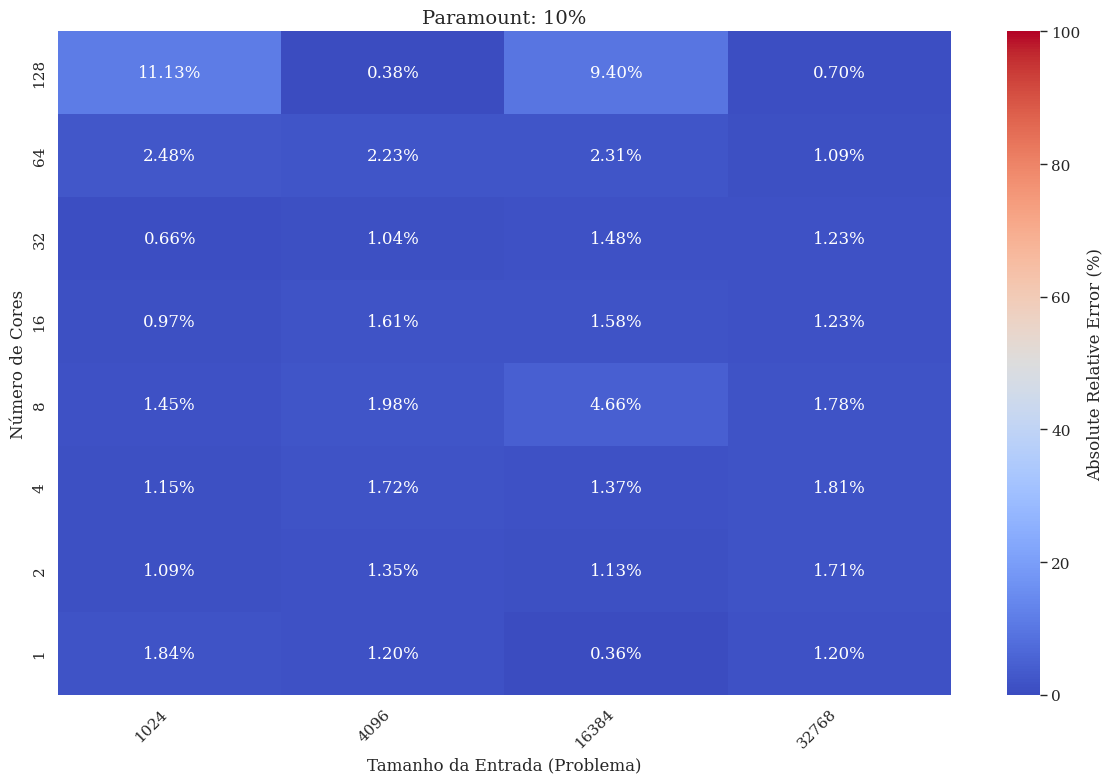

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


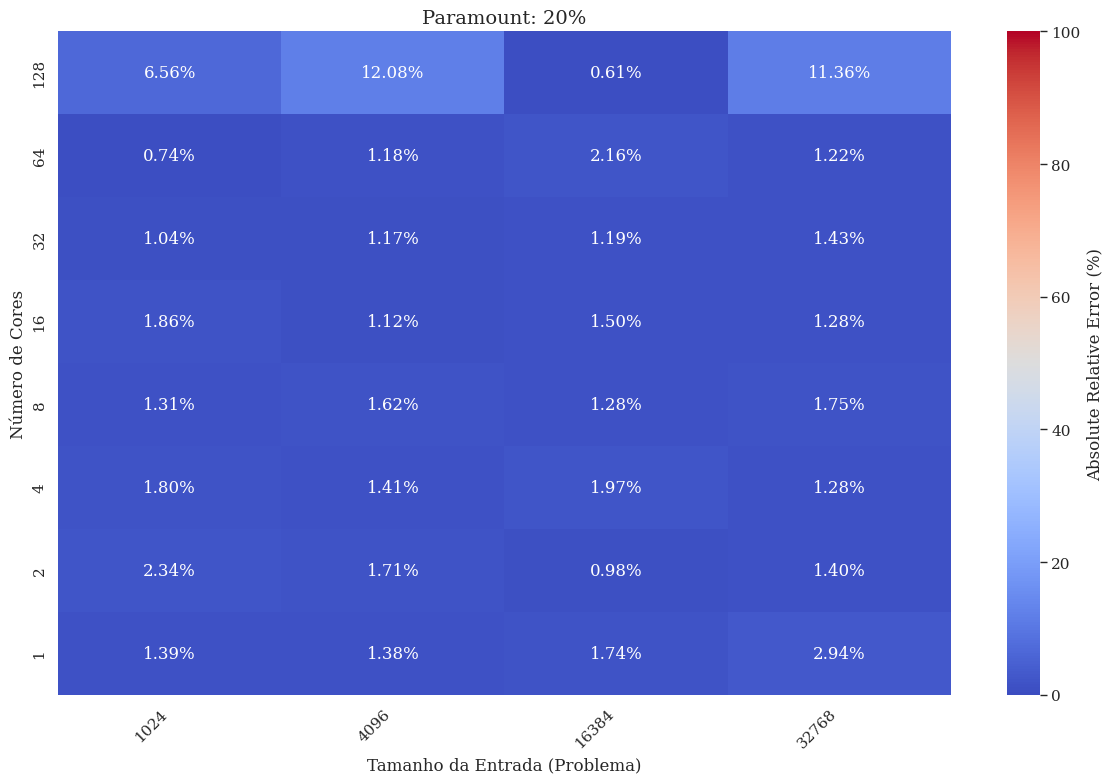

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


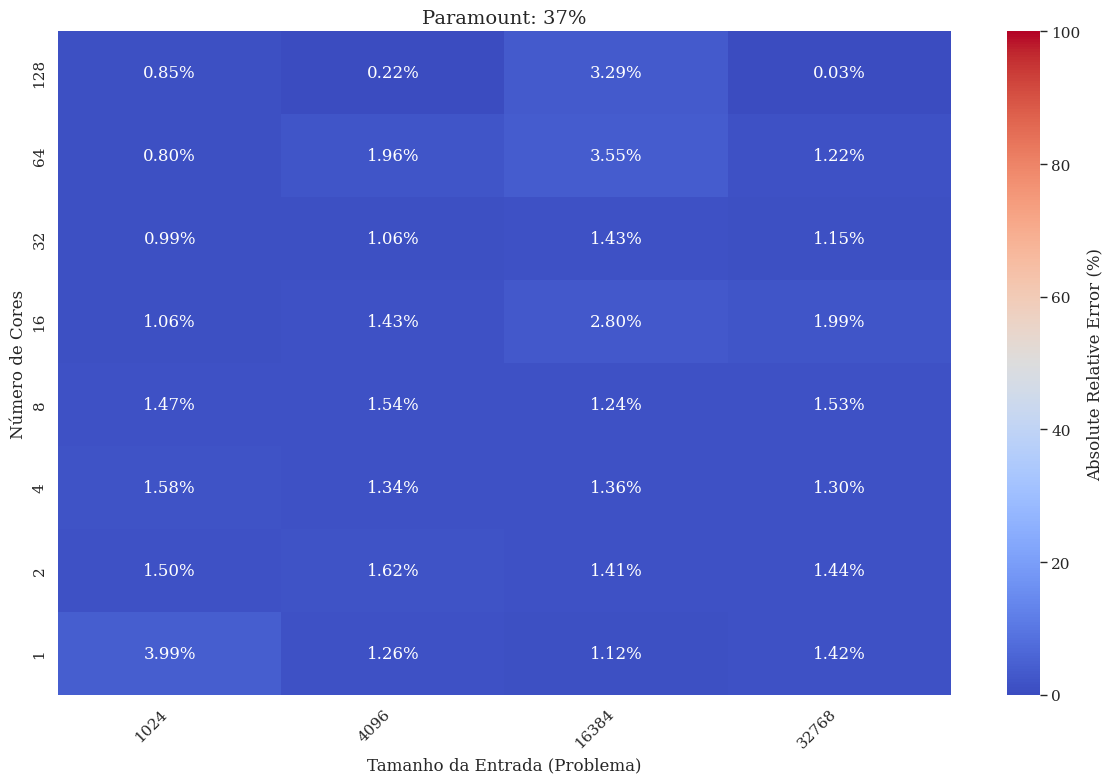

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


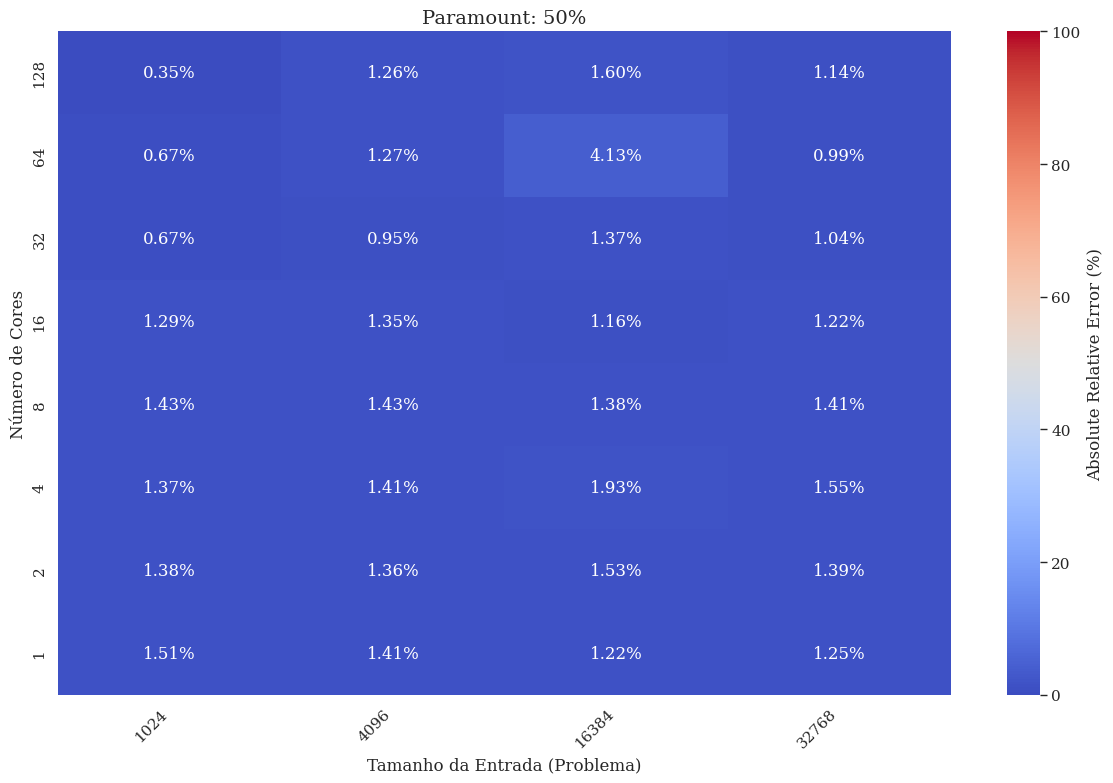

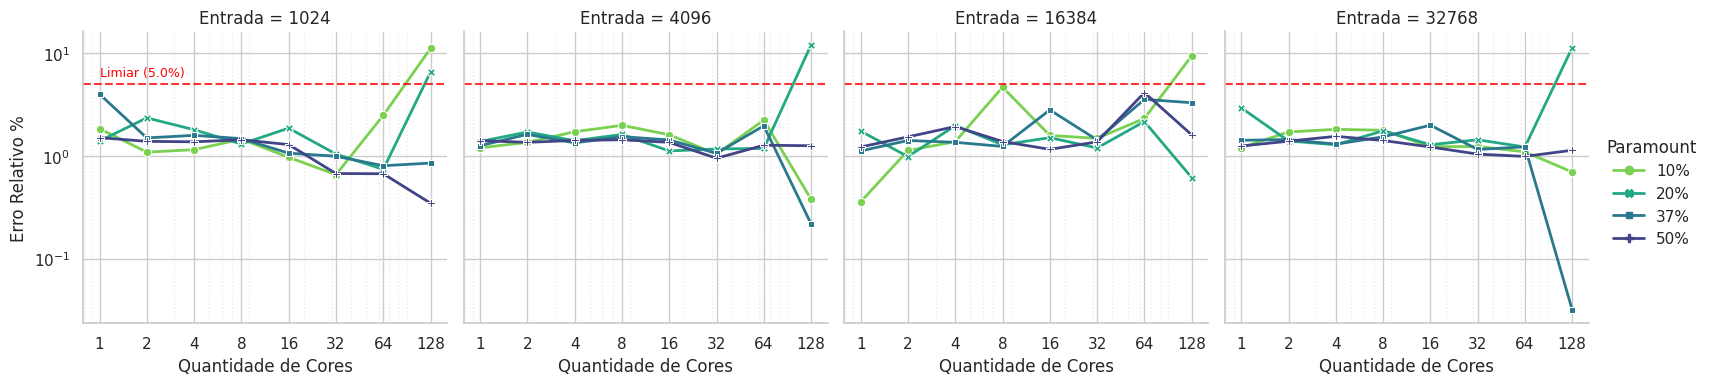

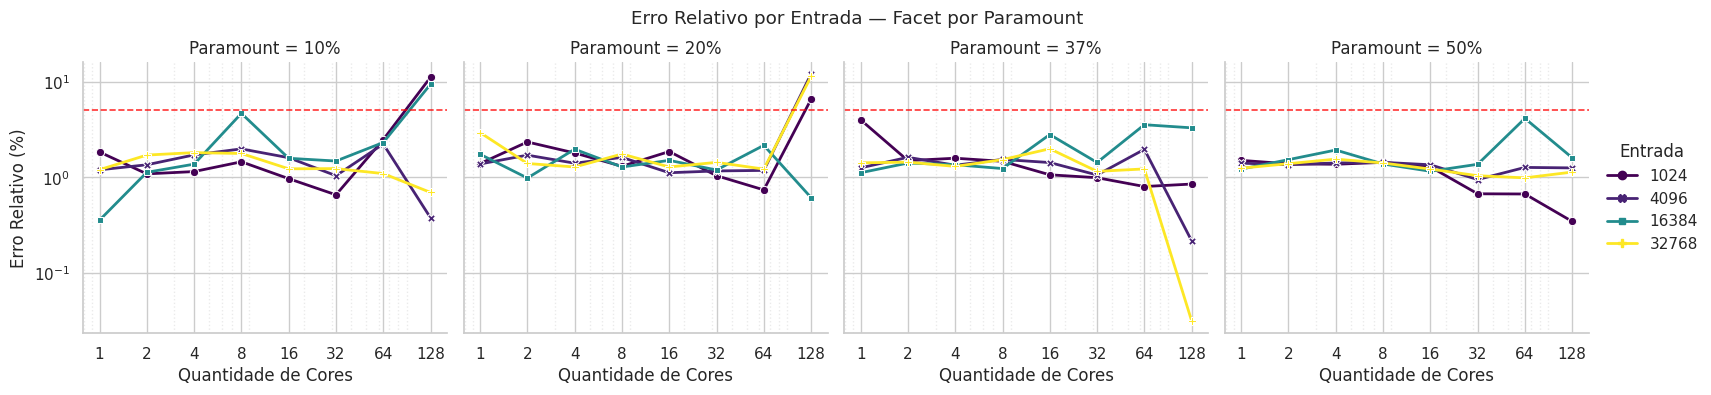

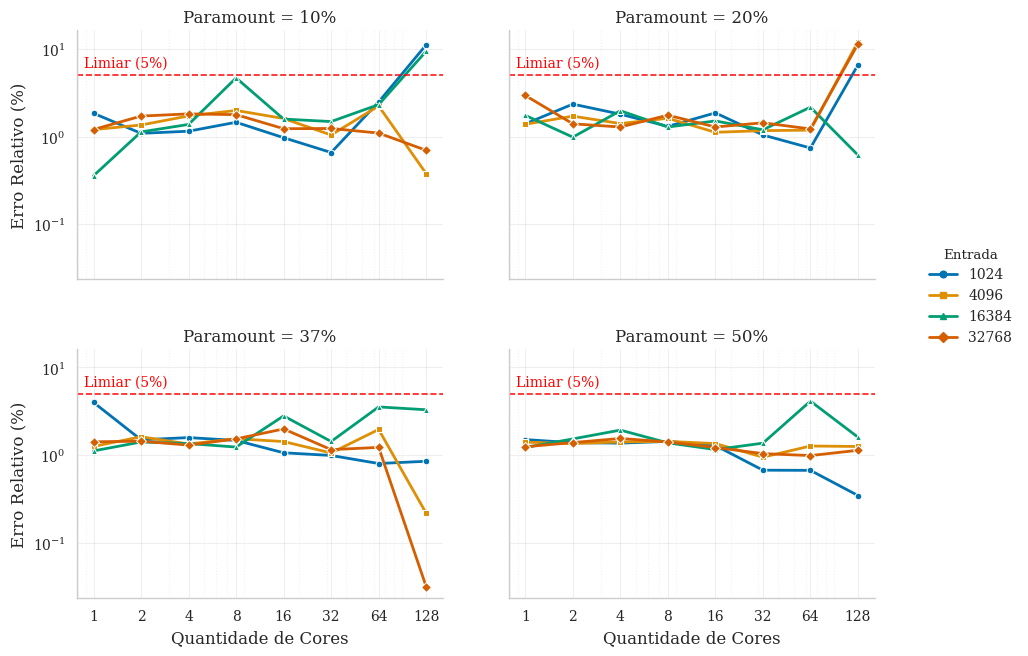

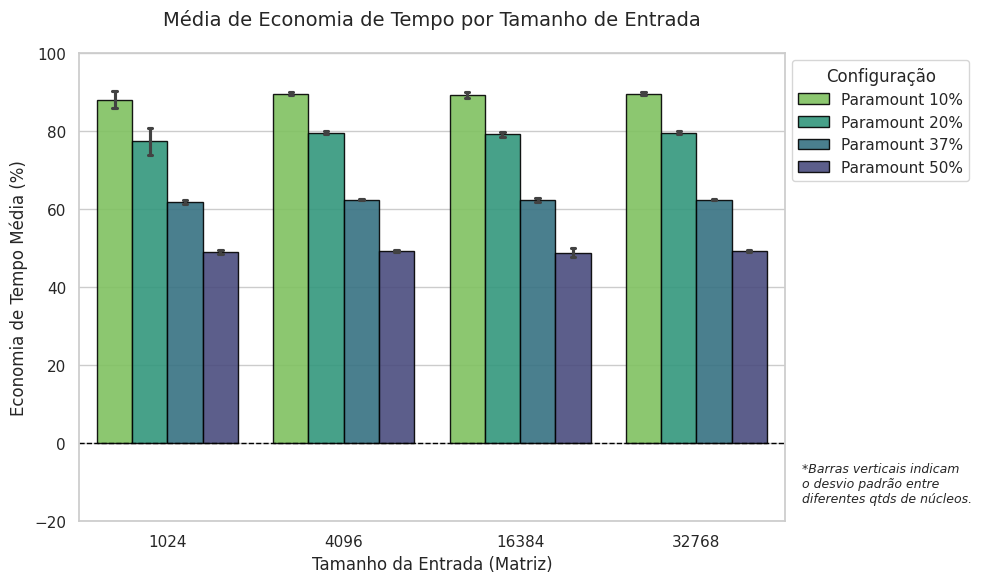

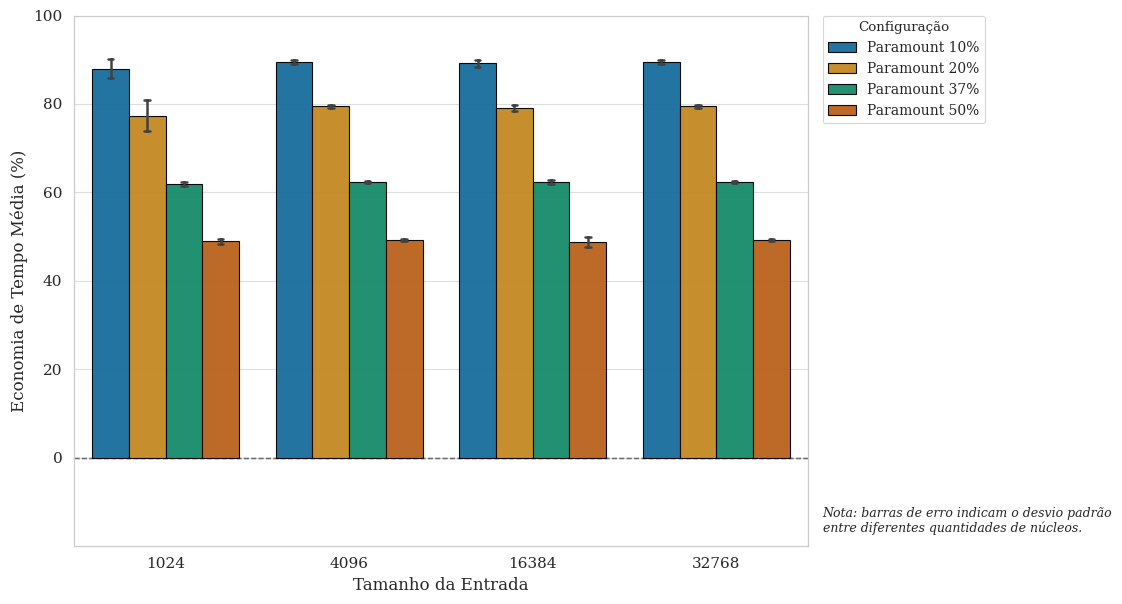

In [40]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "ep-proxy")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

df_gain = generate_gain_graph(app_dir, save_path=None)

APP: /home/reilta/Documents/mestrado/ep-proxy-afinidade
total.out: /home/reilta/Documents/mestrado/ep-proxy-afinidade/out/total.out
total.json: /home/reilta/Documents/mestrado/ep-proxy-afinidade/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 128 linhas | 4 porcentagens


/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


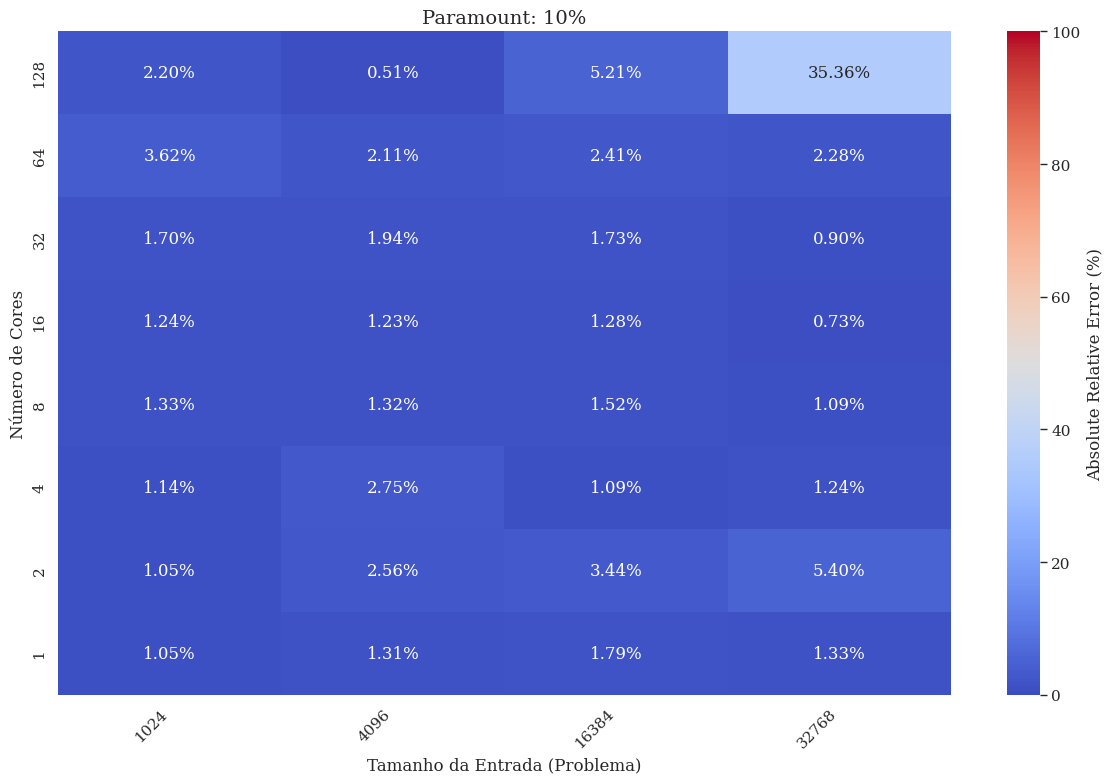

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


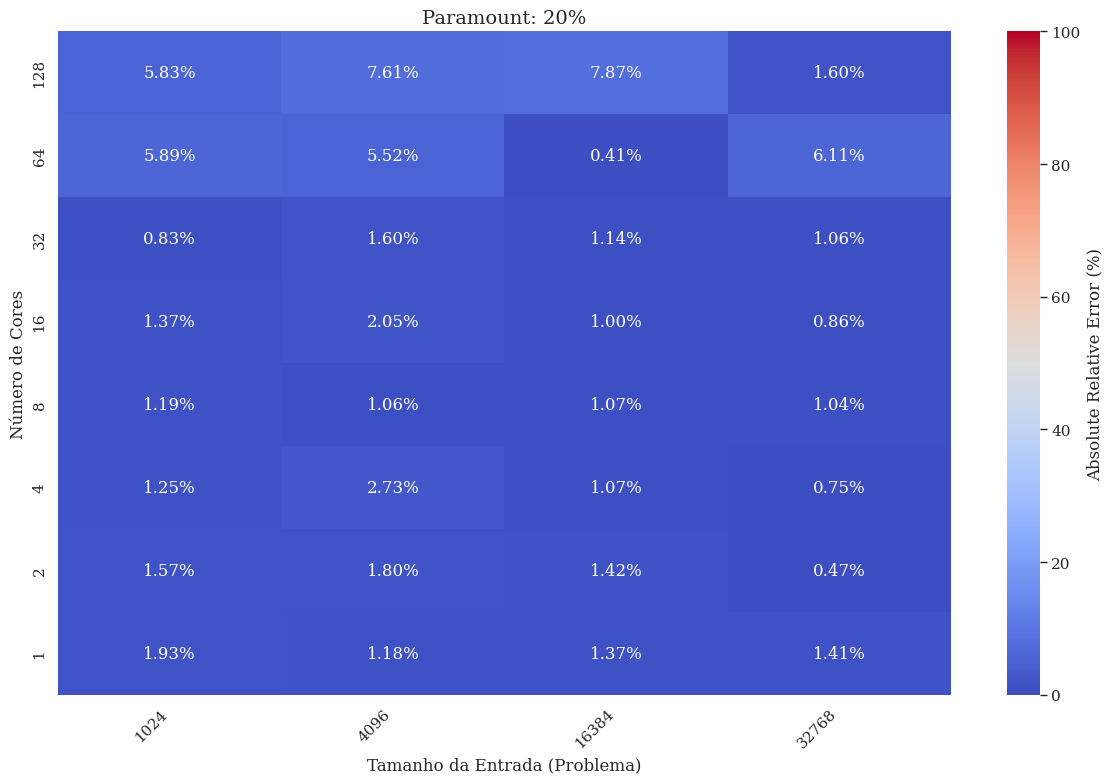

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


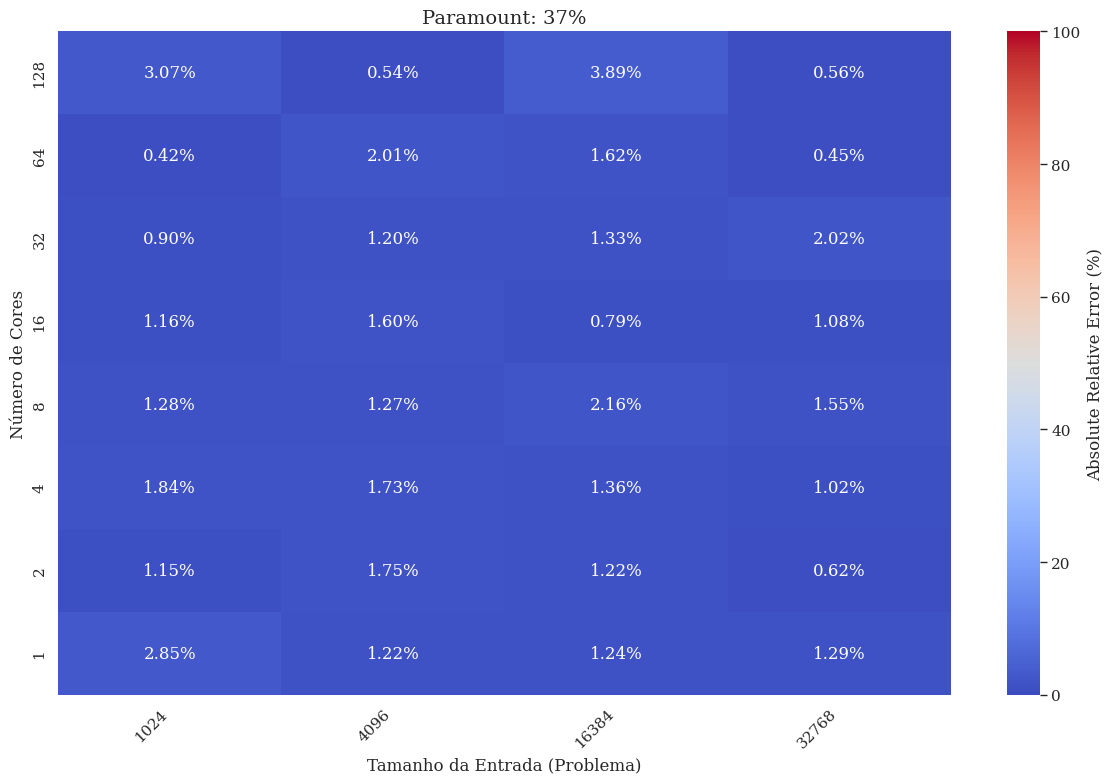

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


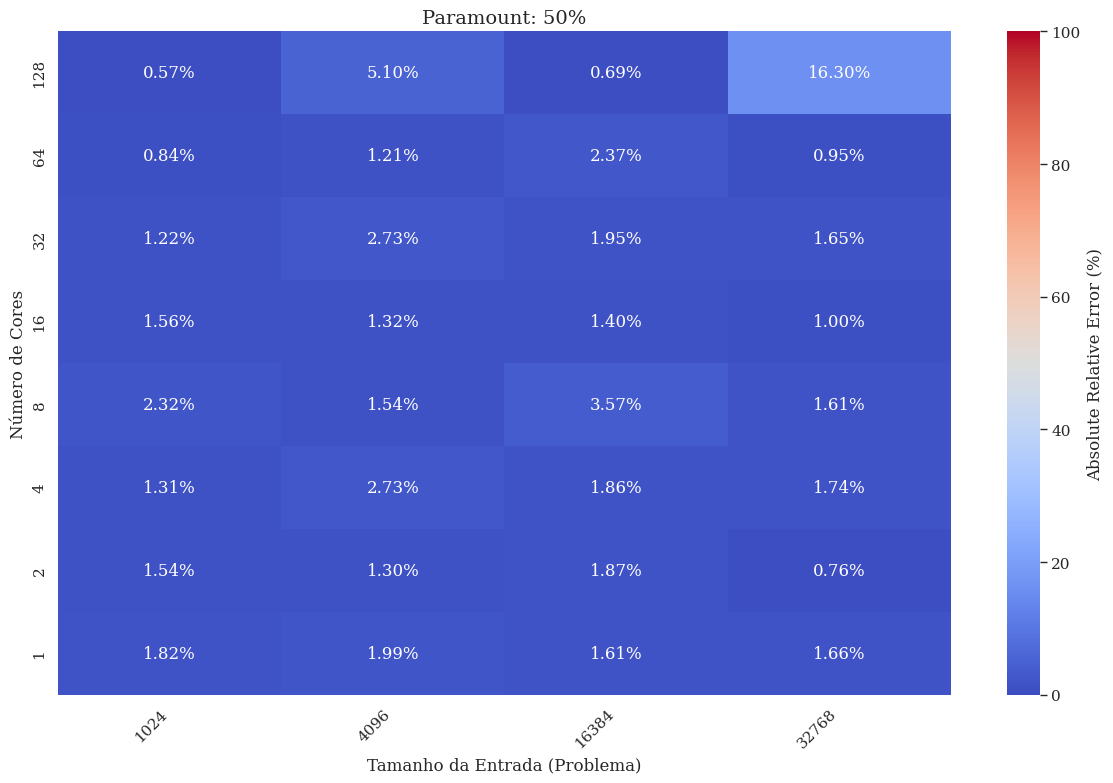

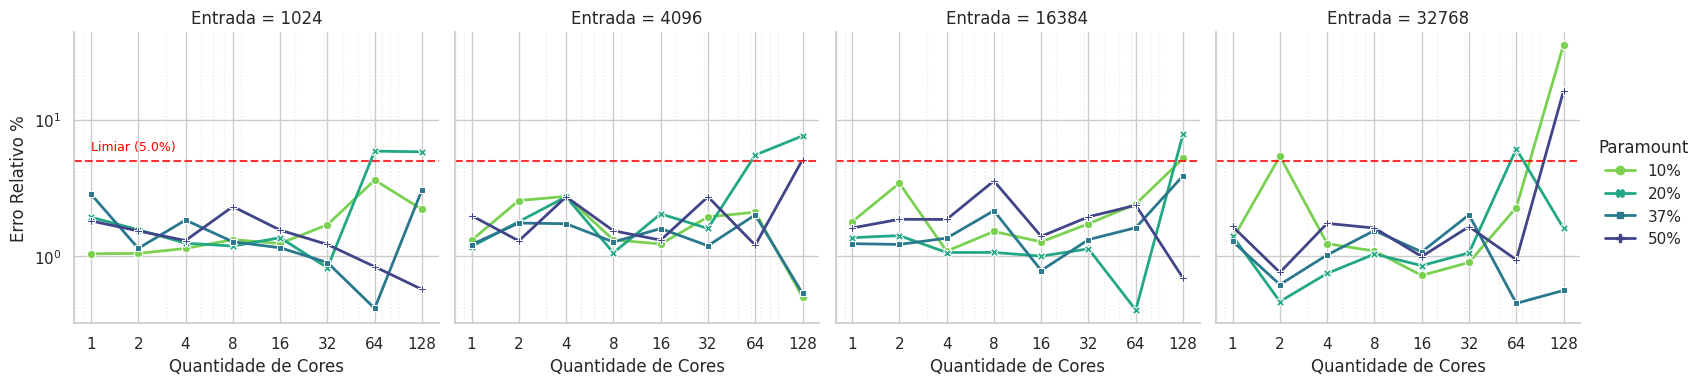

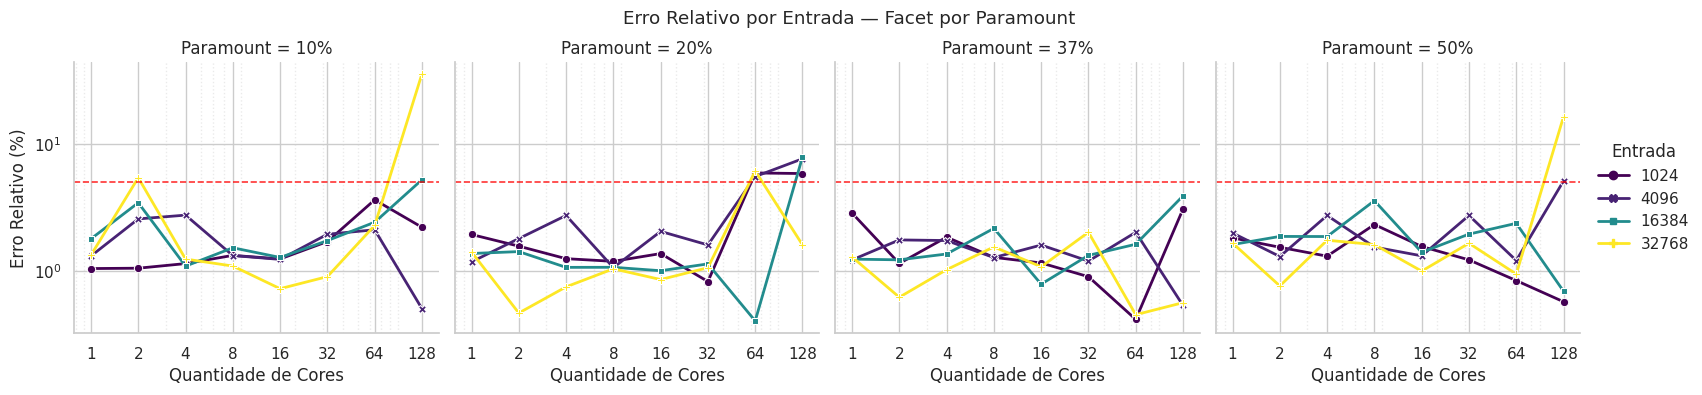

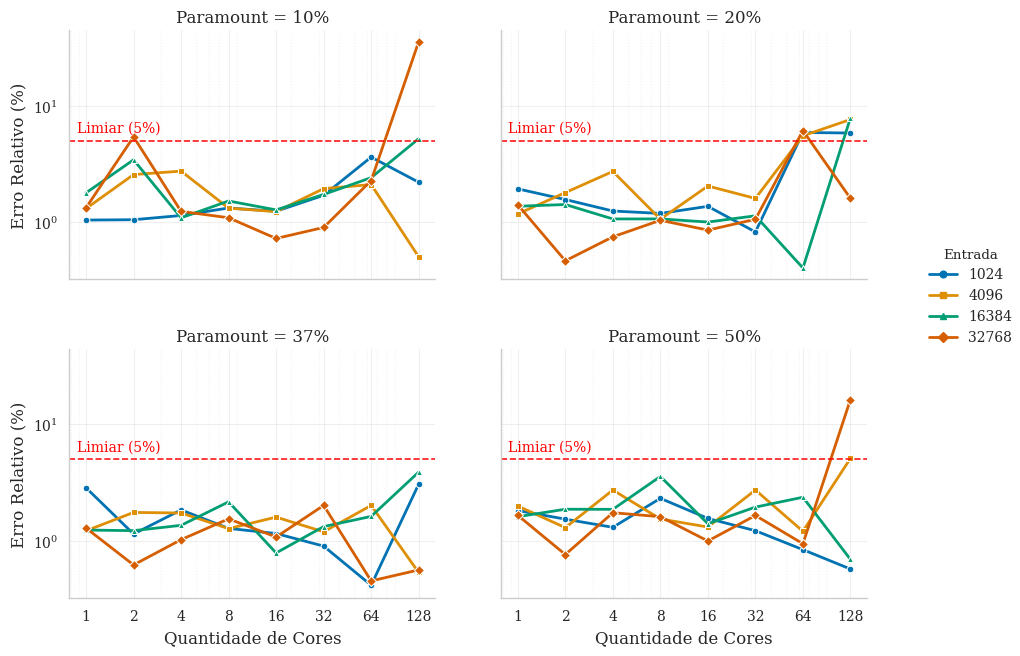

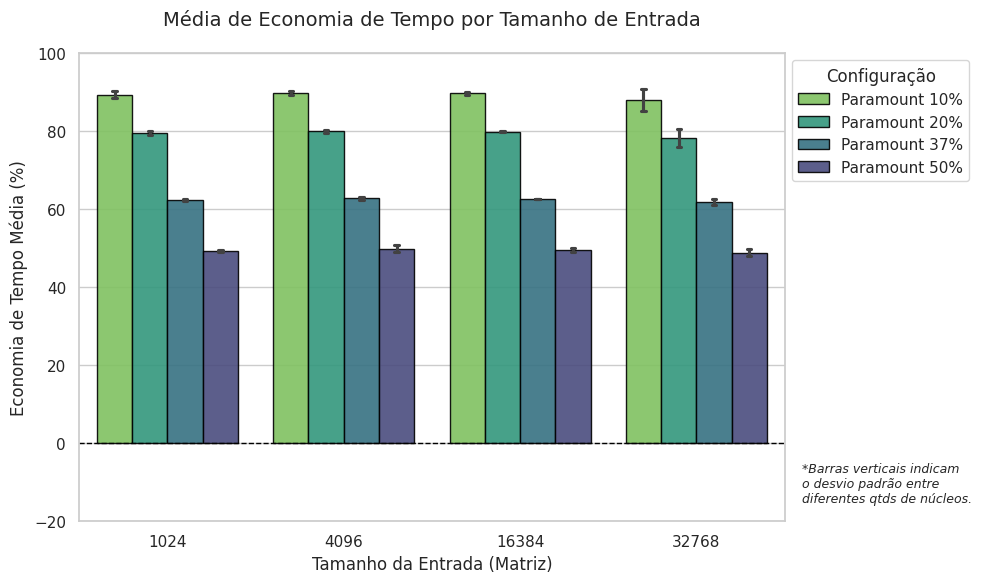

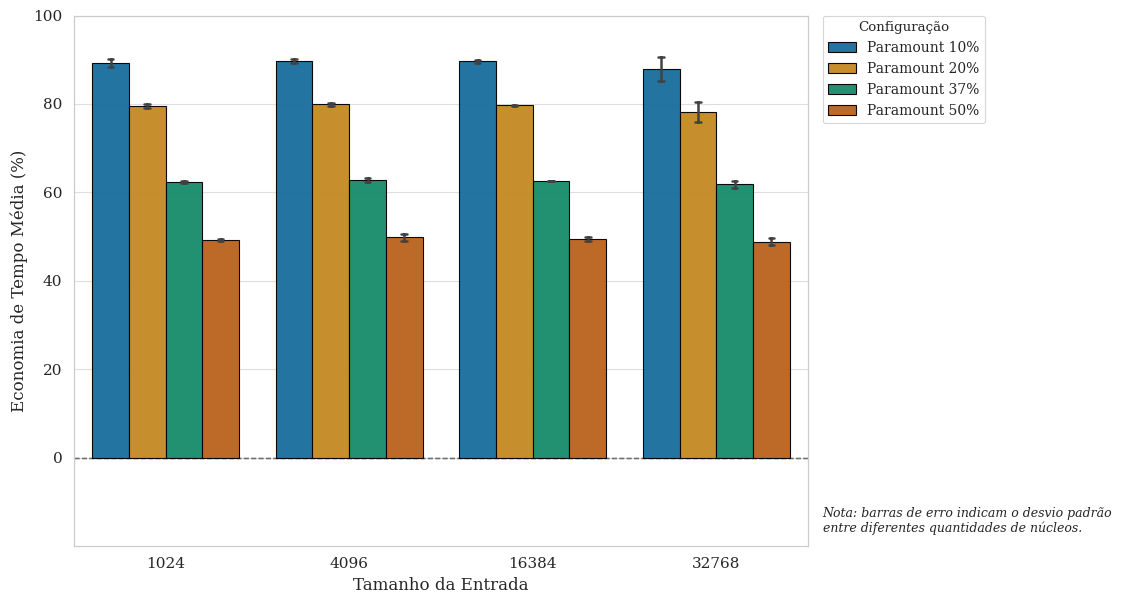

In [41]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "ep-proxy-afinidade")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

df_gain = generate_gain_graph(app_dir, save_path=None)

APP: /home/reilta/Documents/mestrado/mandelbrot
total.out: /home/reilta/Documents/mestrado/mandelbrot/out/total.out
total.json: /home/reilta/Documents/mestrado/mandelbrot/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 128 linhas | 4 porcentagens


/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


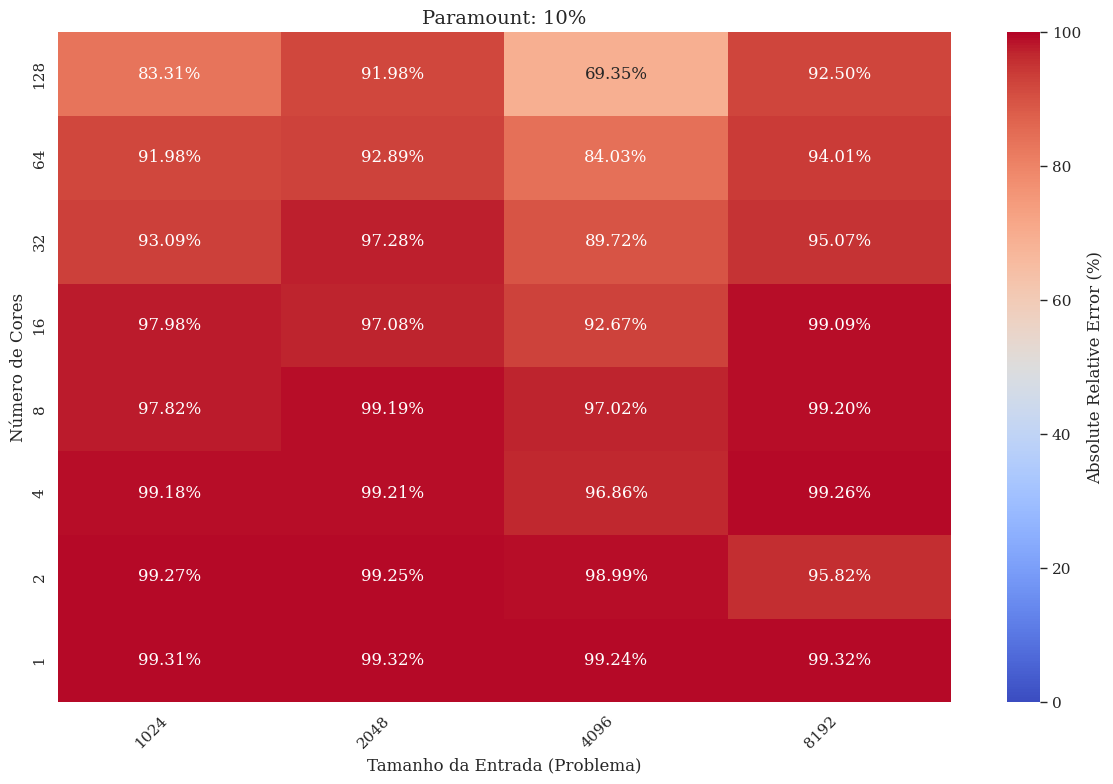

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


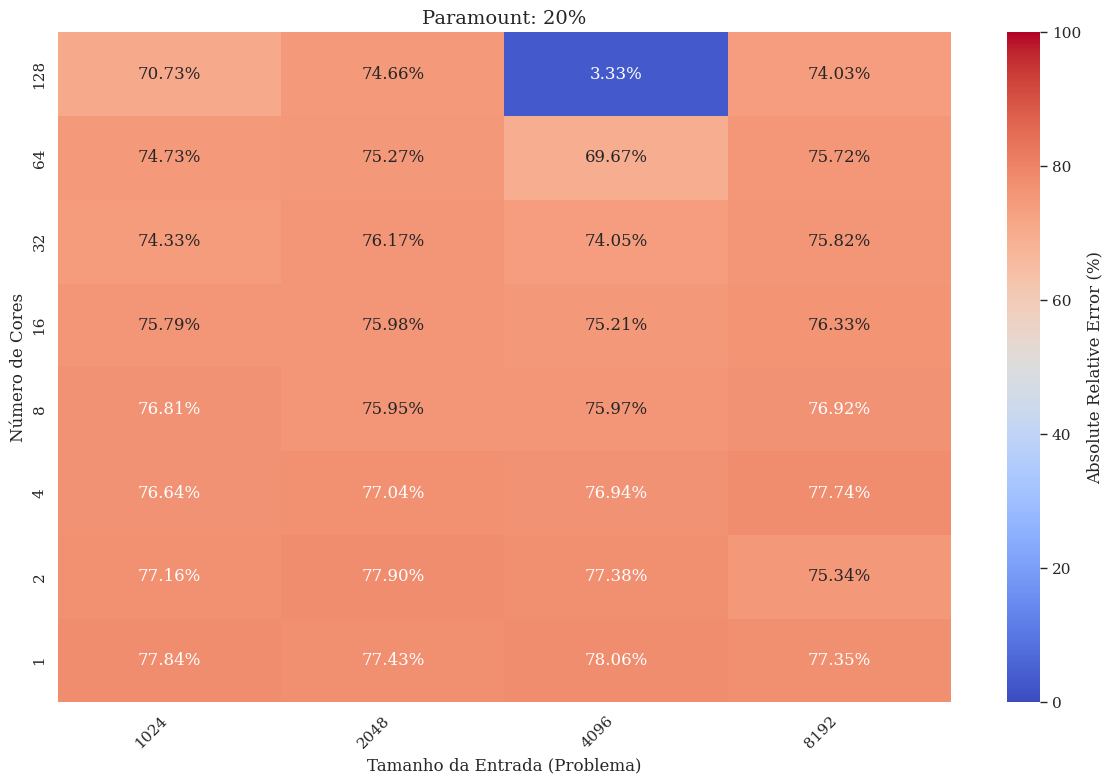

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


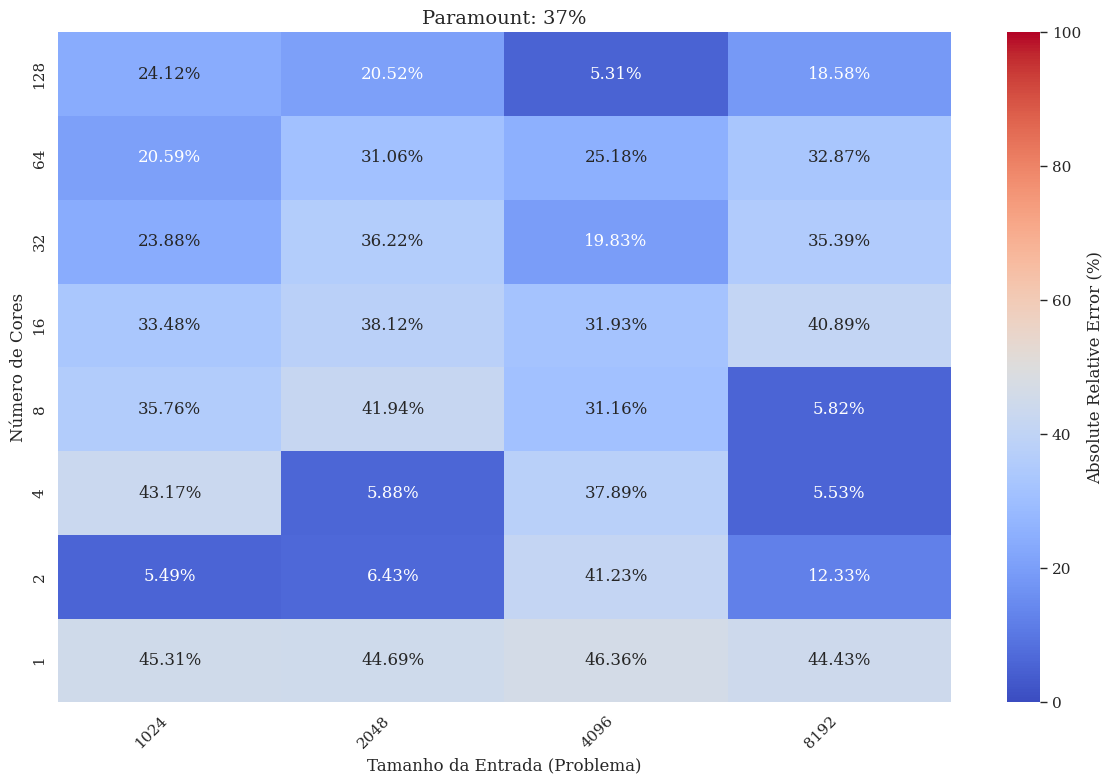

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


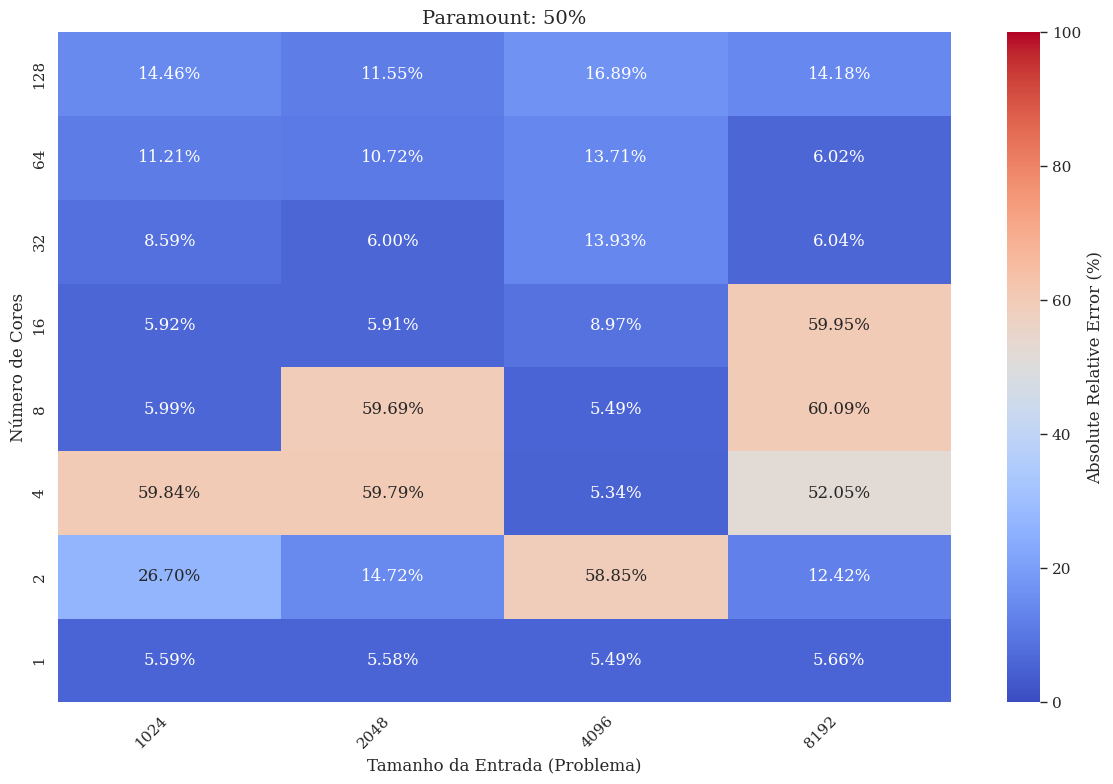

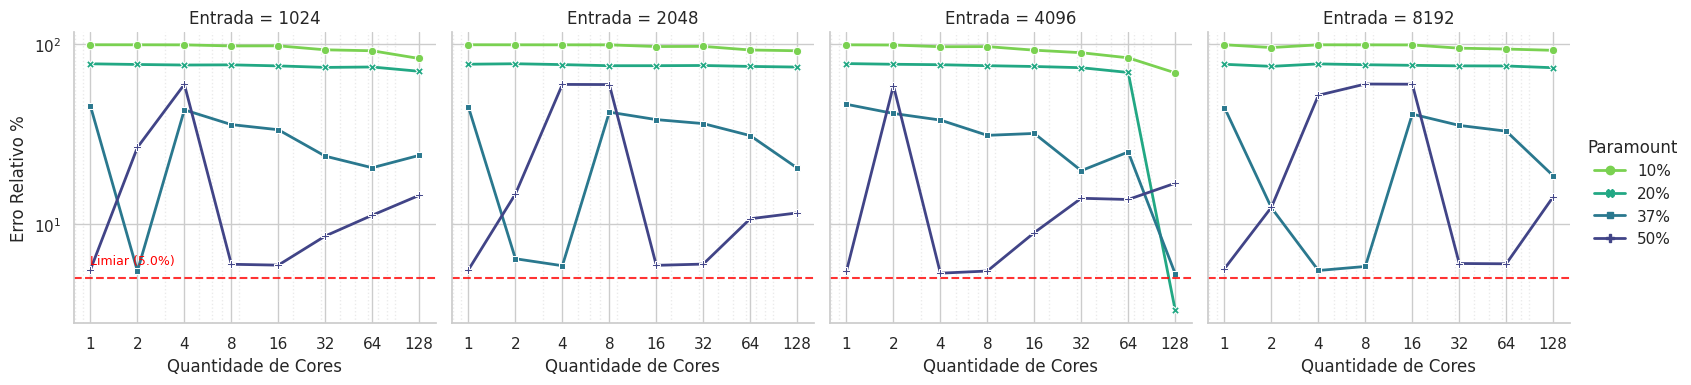

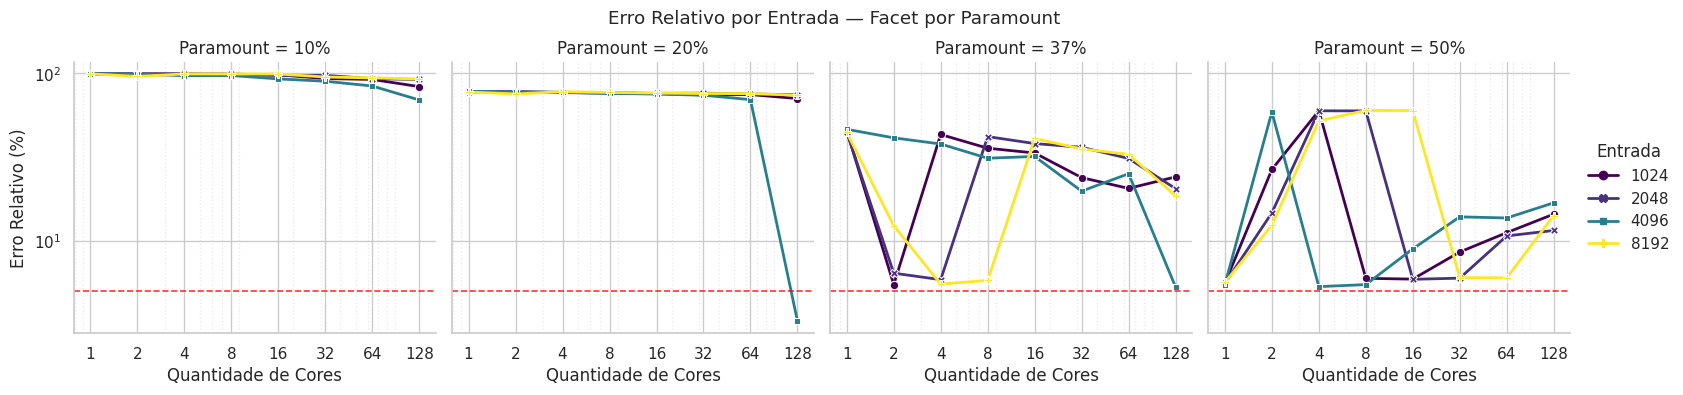

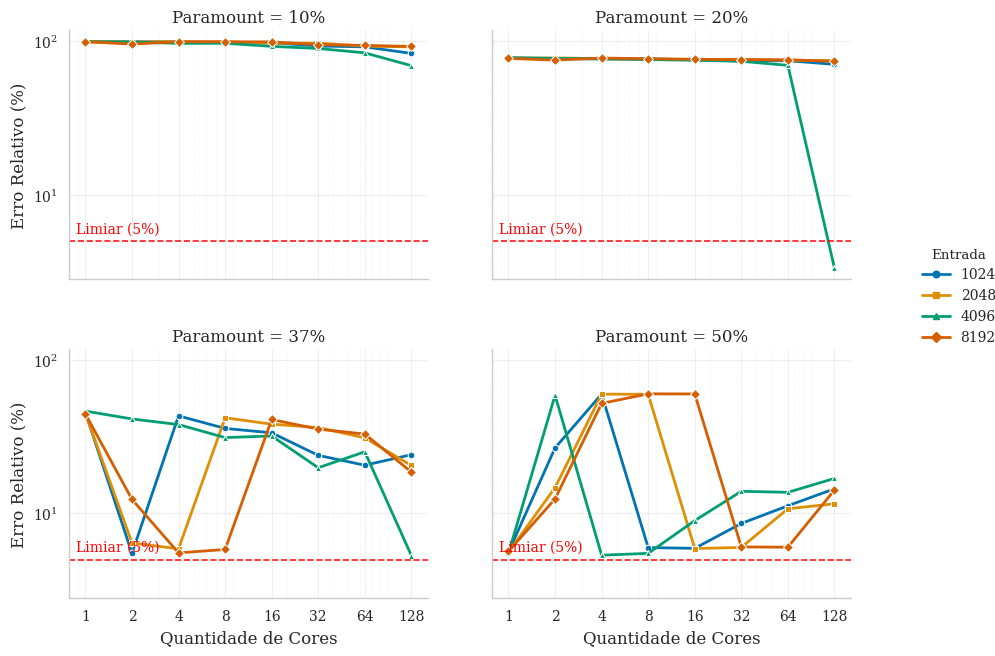

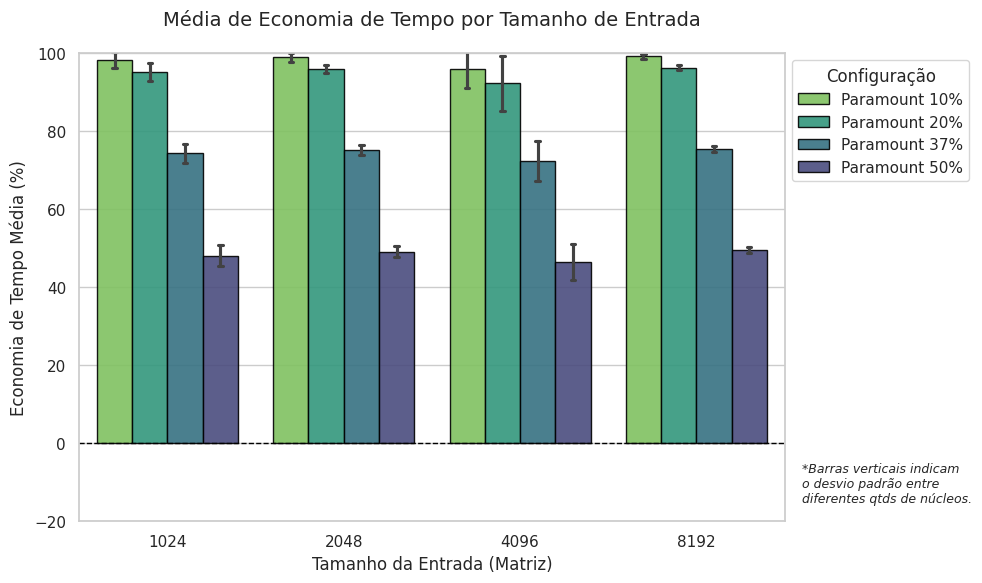

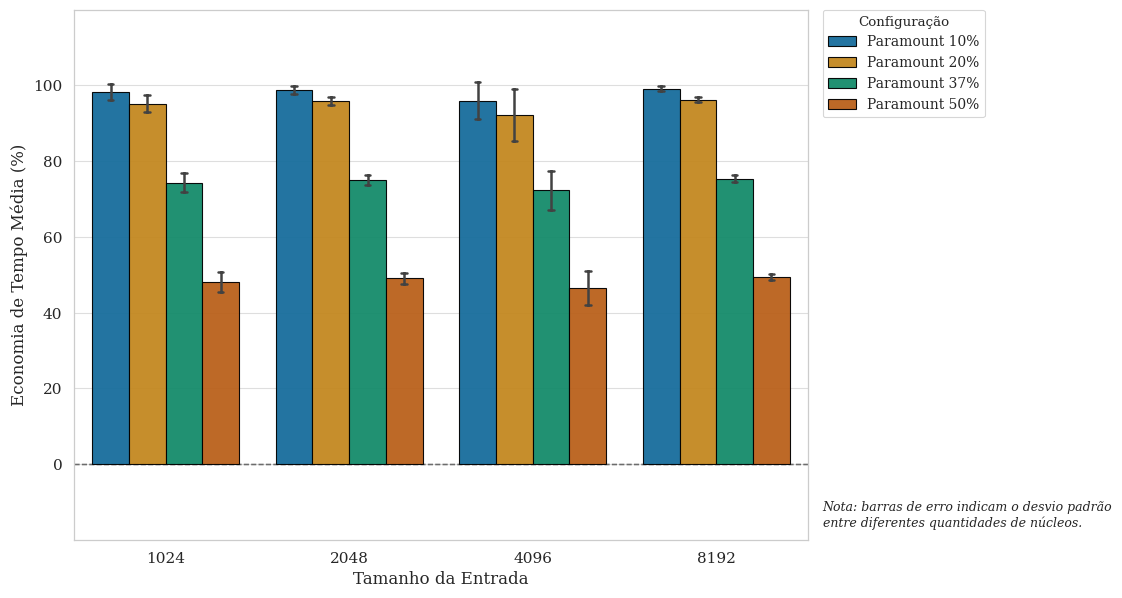

In [45]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "mandelbrot")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

df_gain = generate_gain_graph(app_dir, save_path=None)

APP: /home/reilta/Documents/mestrado/mandelbrot-afinidade
total.out: /home/reilta/Documents/mestrado/mandelbrot-afinidade/out/total.out
total.json: /home/reilta/Documents/mestrado/mandelbrot-afinidade/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 128 linhas | 4 porcentagens


/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


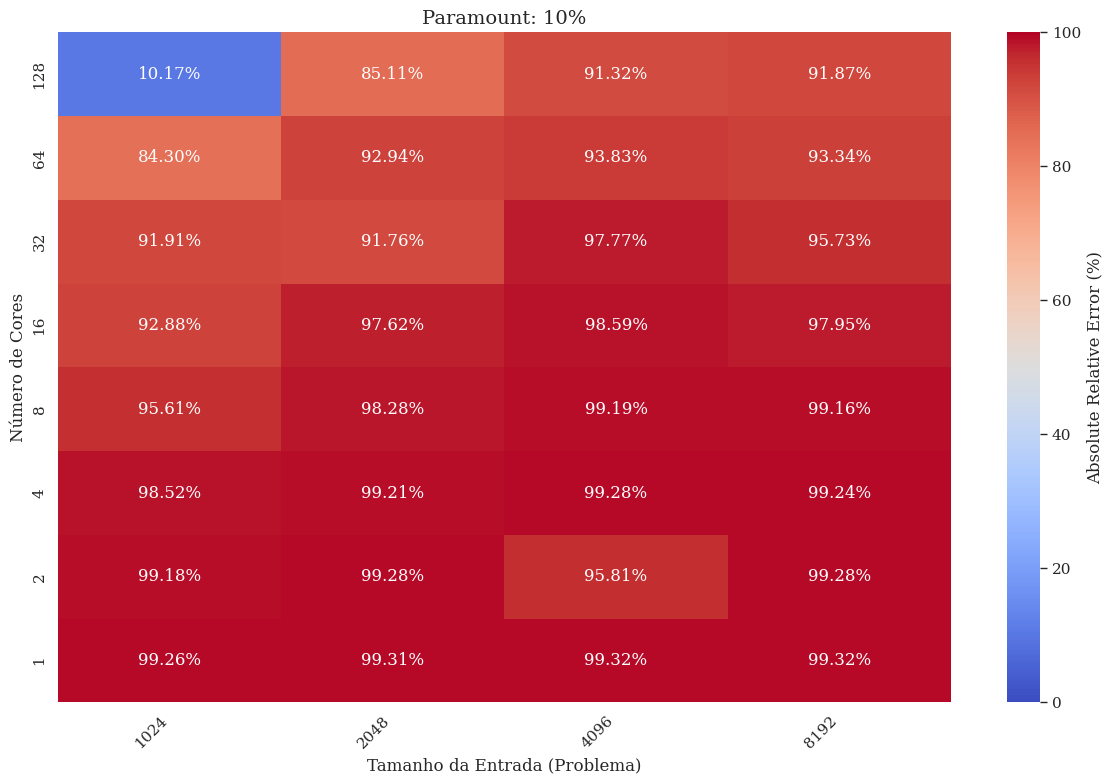

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


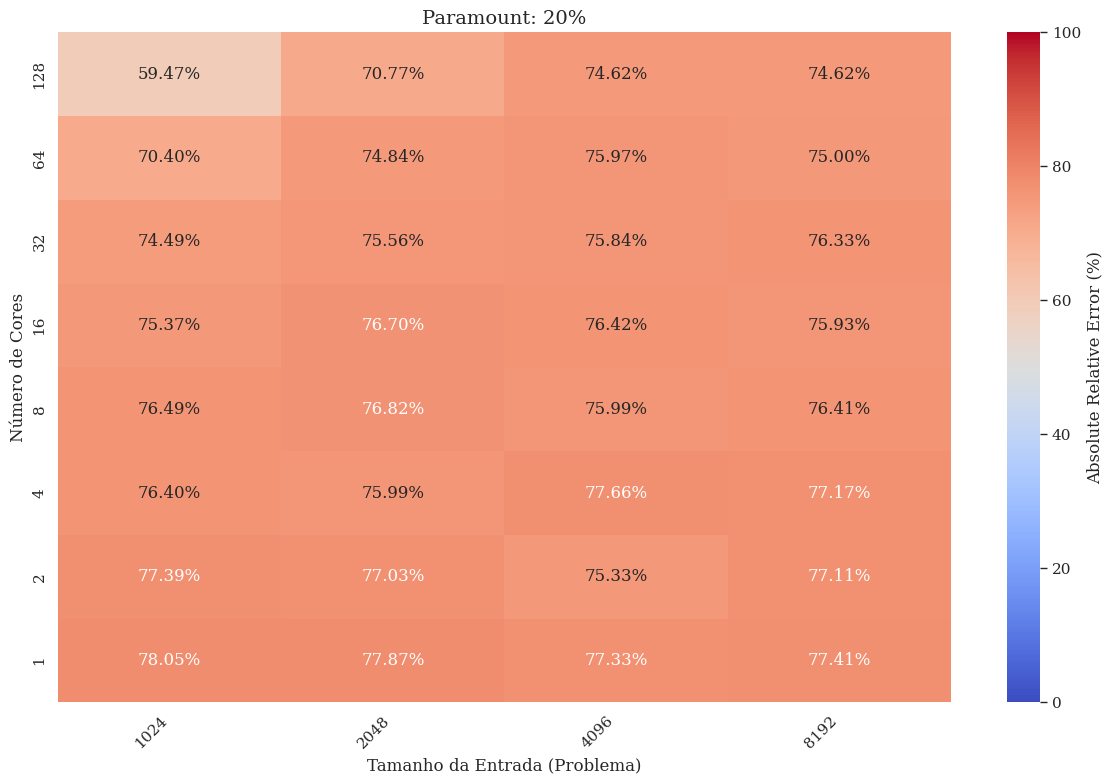

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


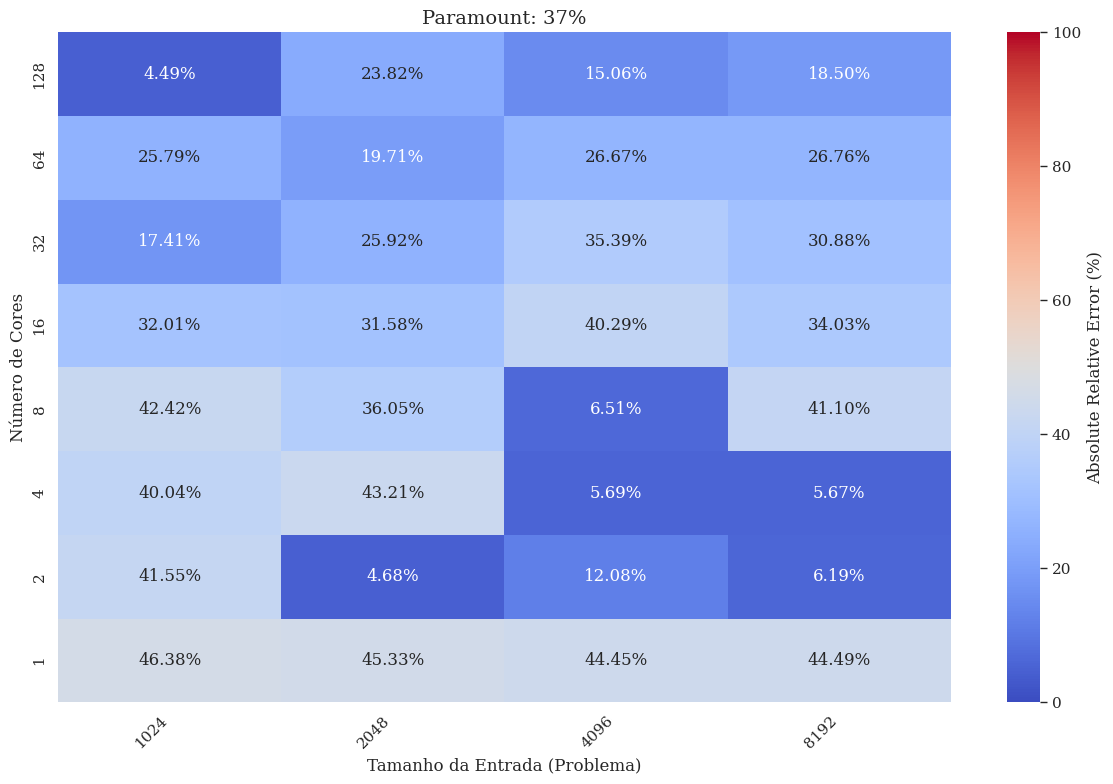

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


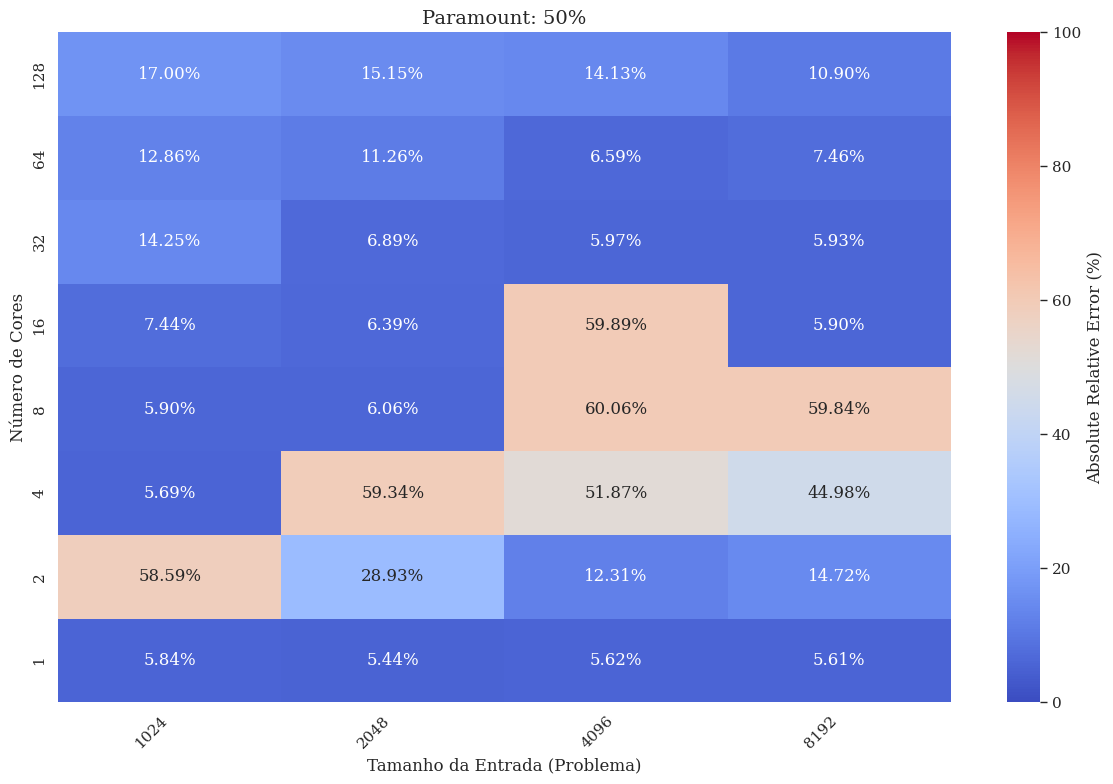

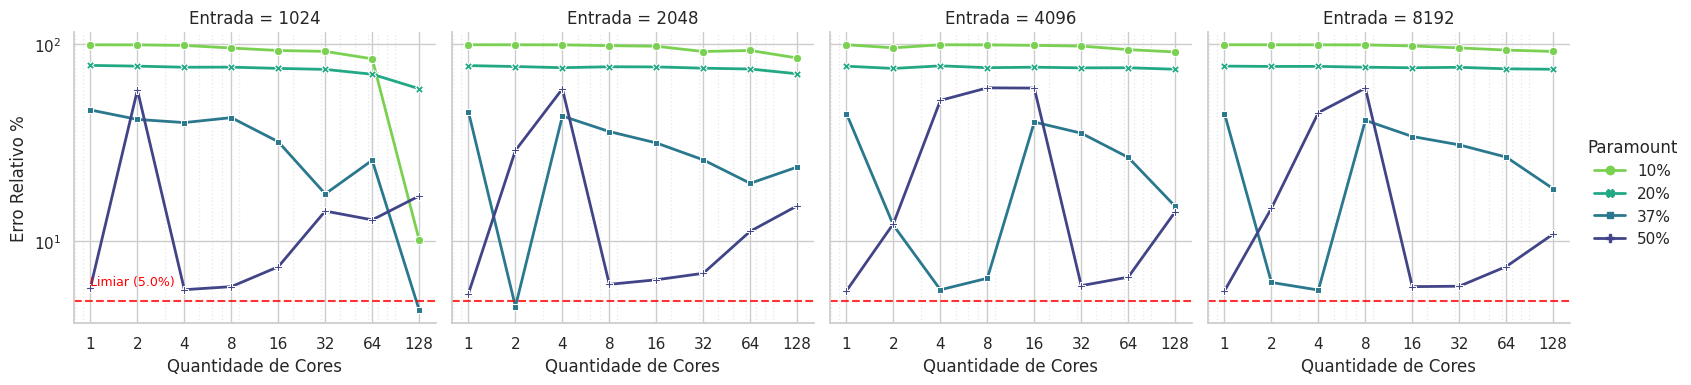

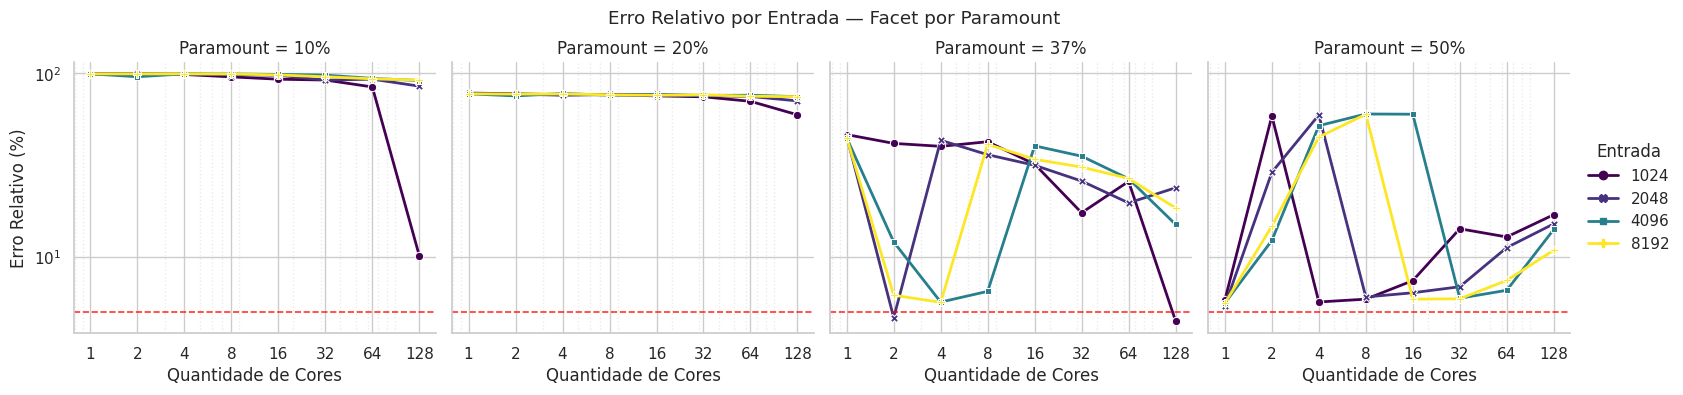

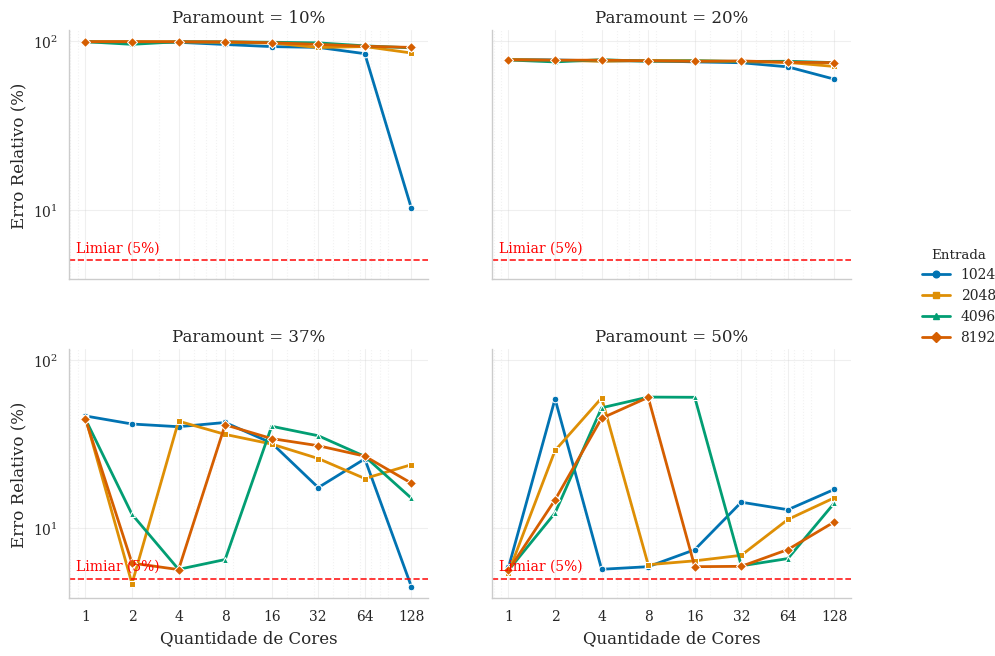

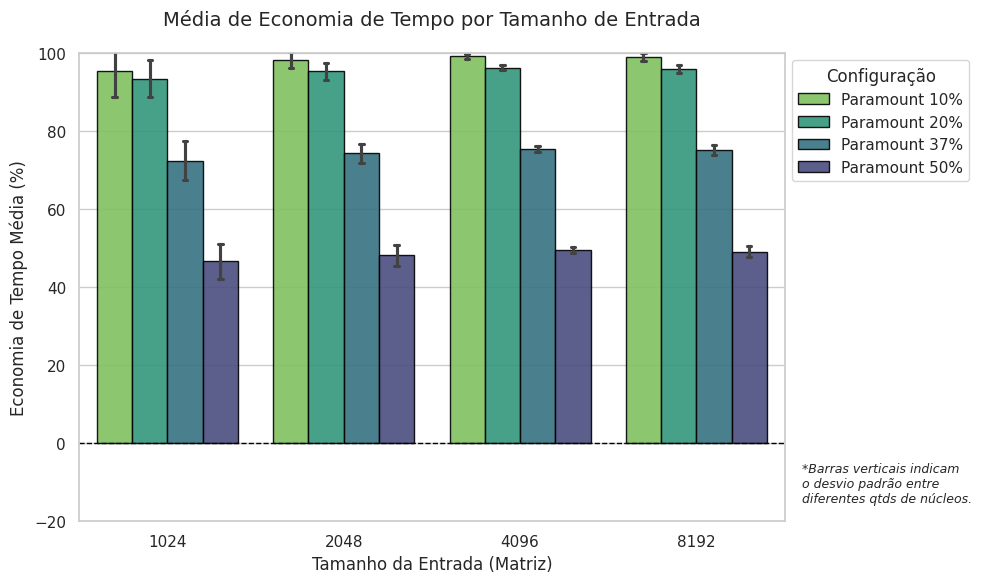

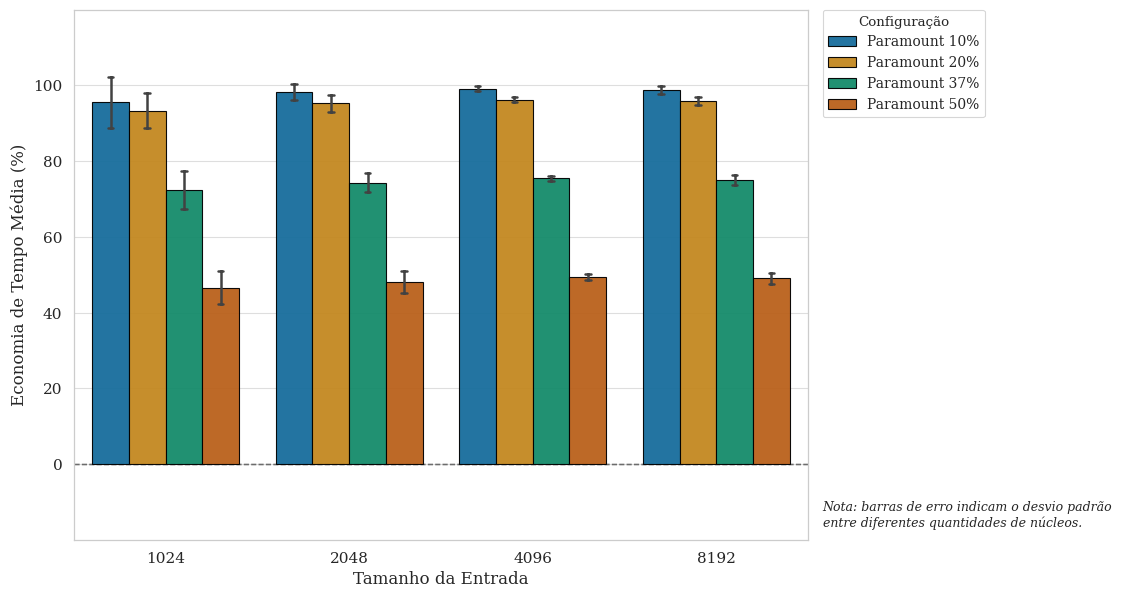

In [46]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "mandelbrot-afinidade")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

df_gain = generate_gain_graph(app_dir, save_path=None)

APP: /home/reilta/Documents/mestrado/matrix-multiplication
total.out: /home/reilta/Documents/mestrado/matrix-multiplication/out/total.out
total.json: /home/reilta/Documents/mestrado/matrix-multiplication/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 160 linhas | 4 porcentagens


/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


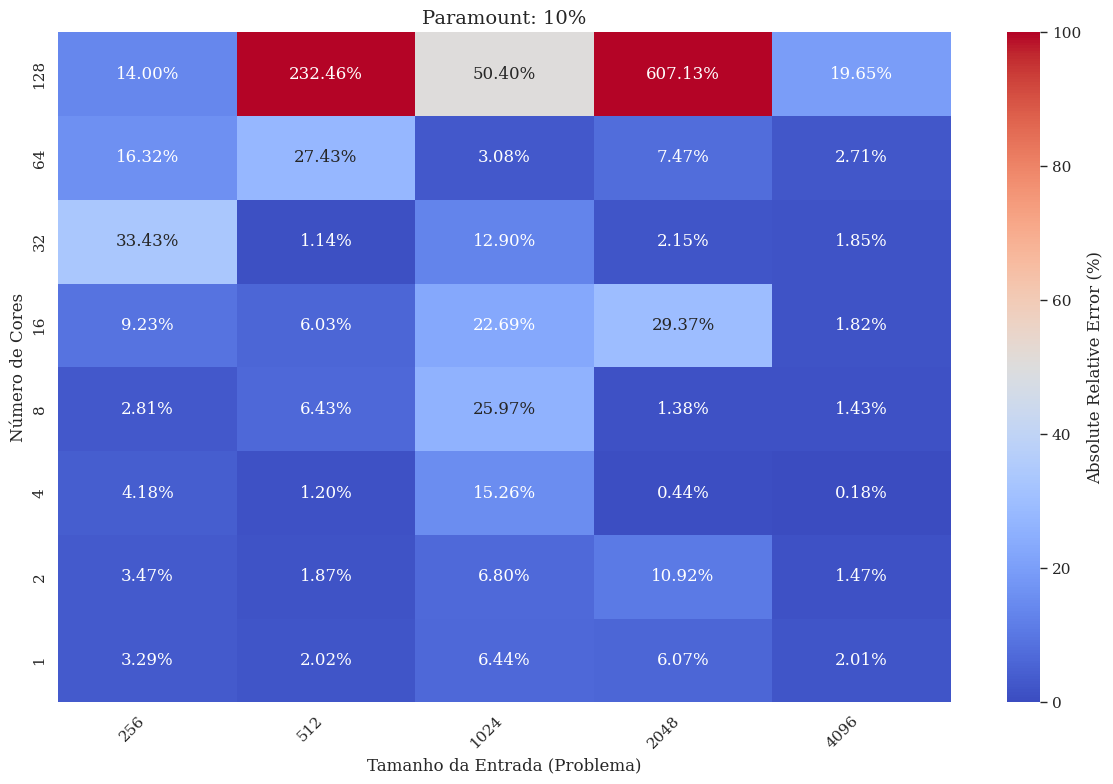

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


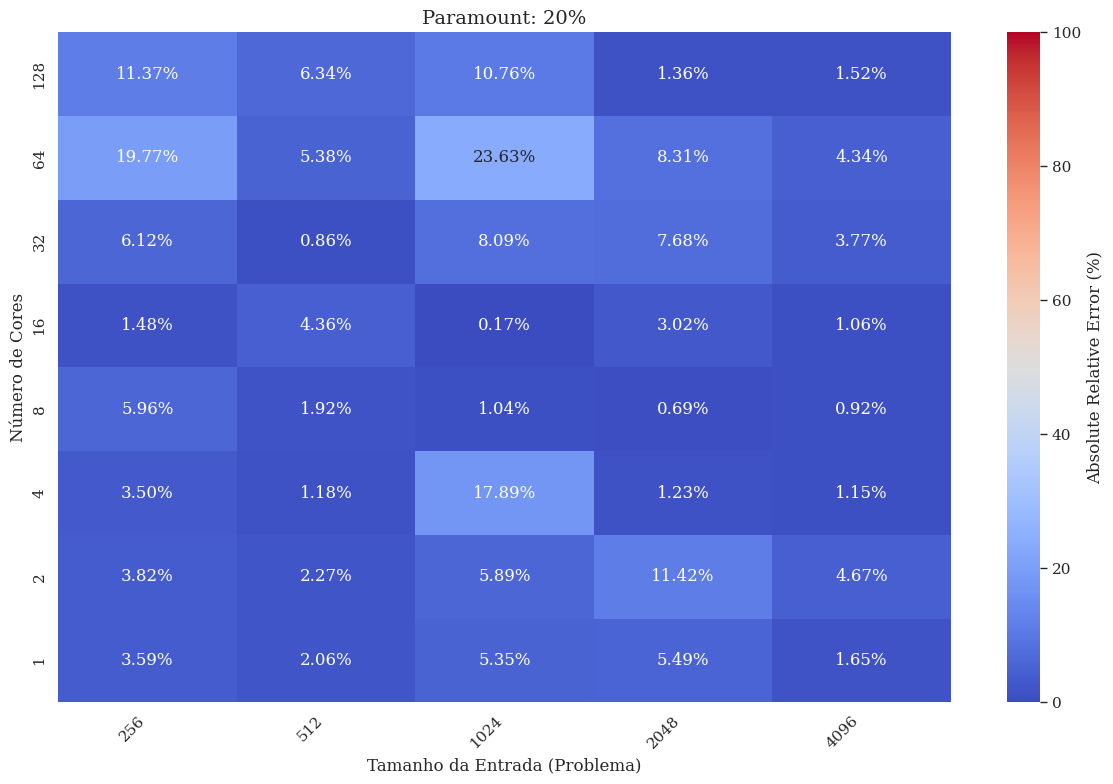

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


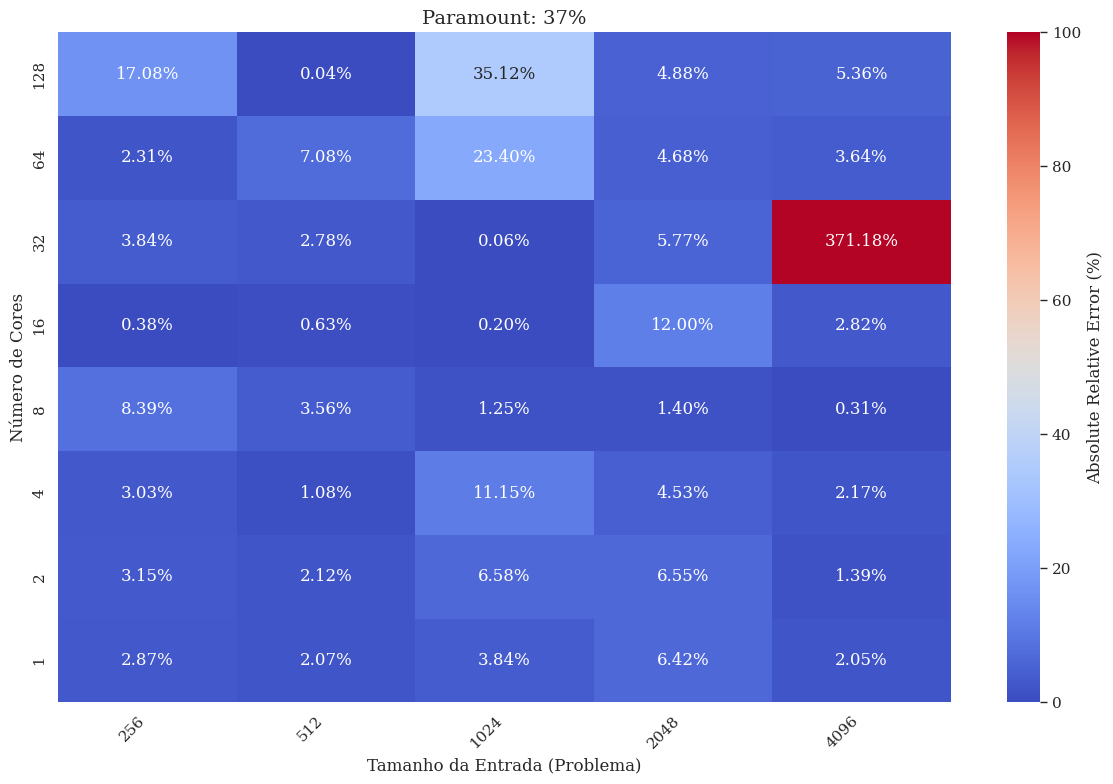

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


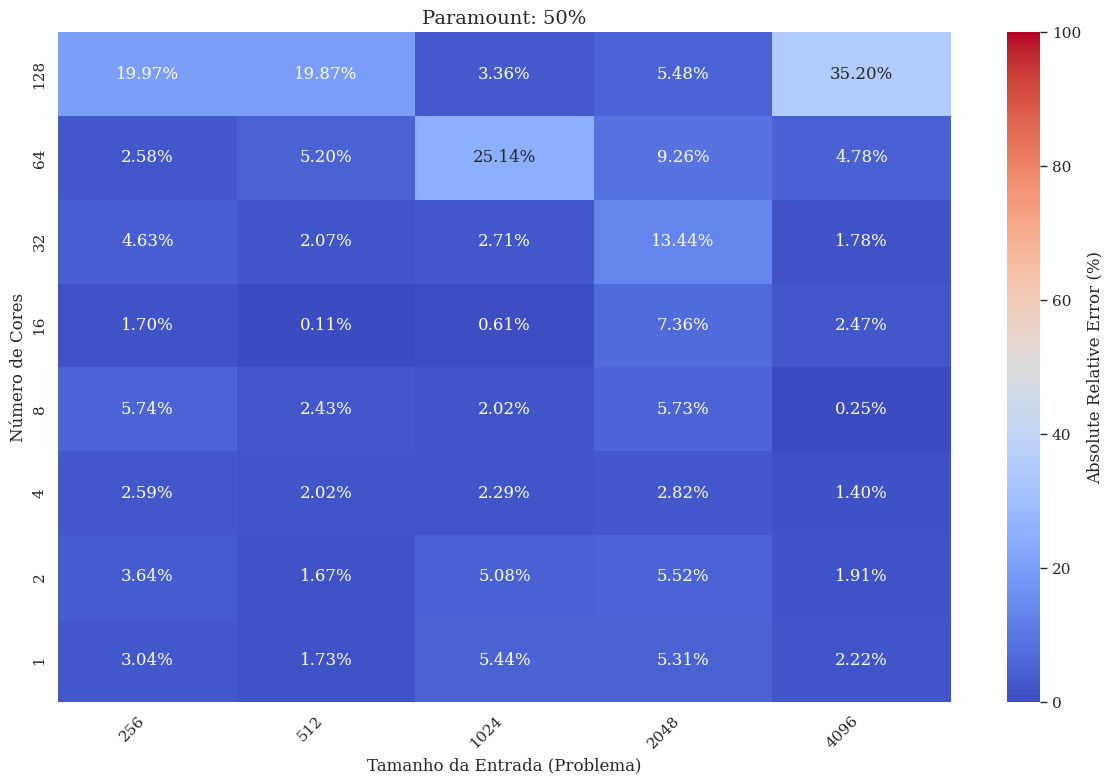

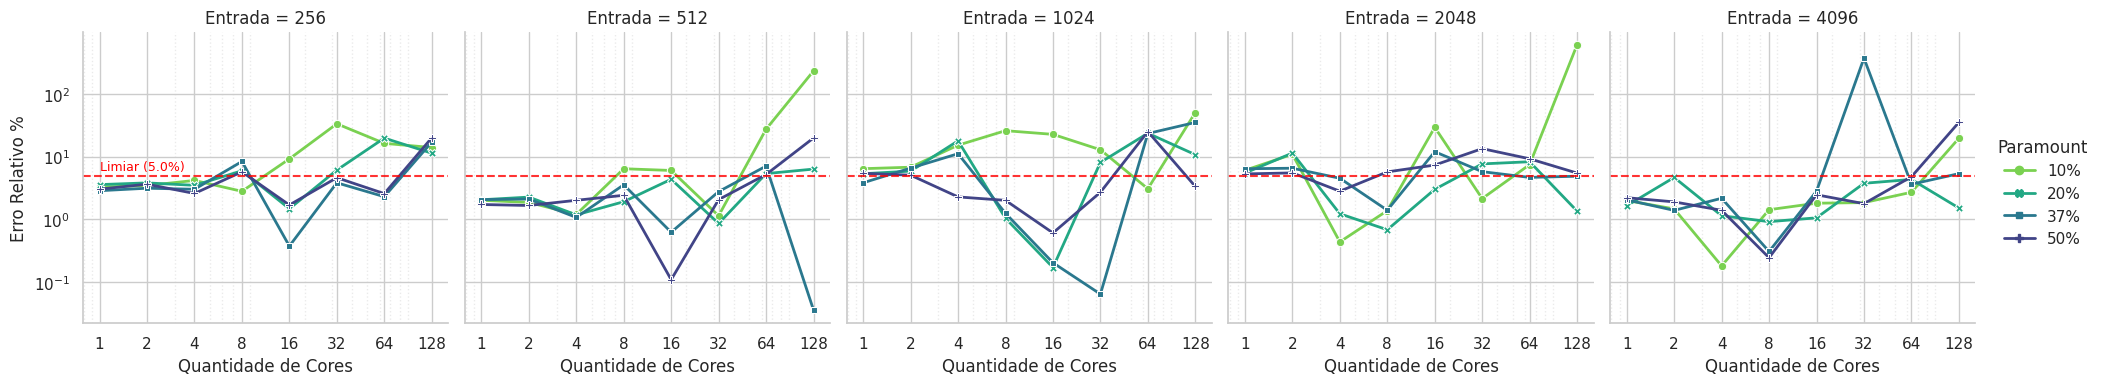

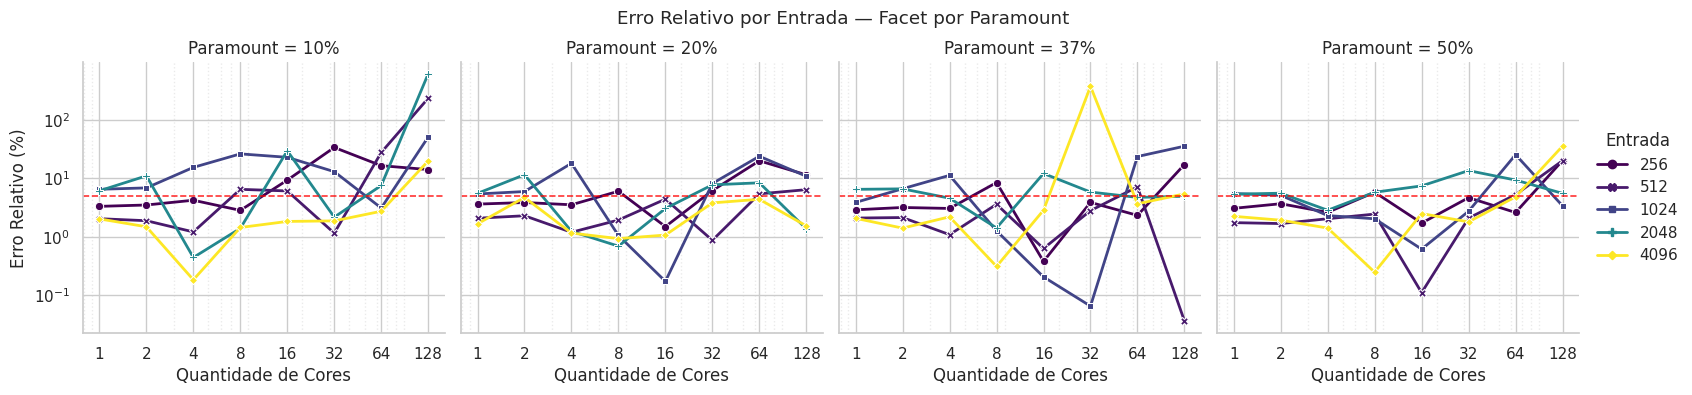

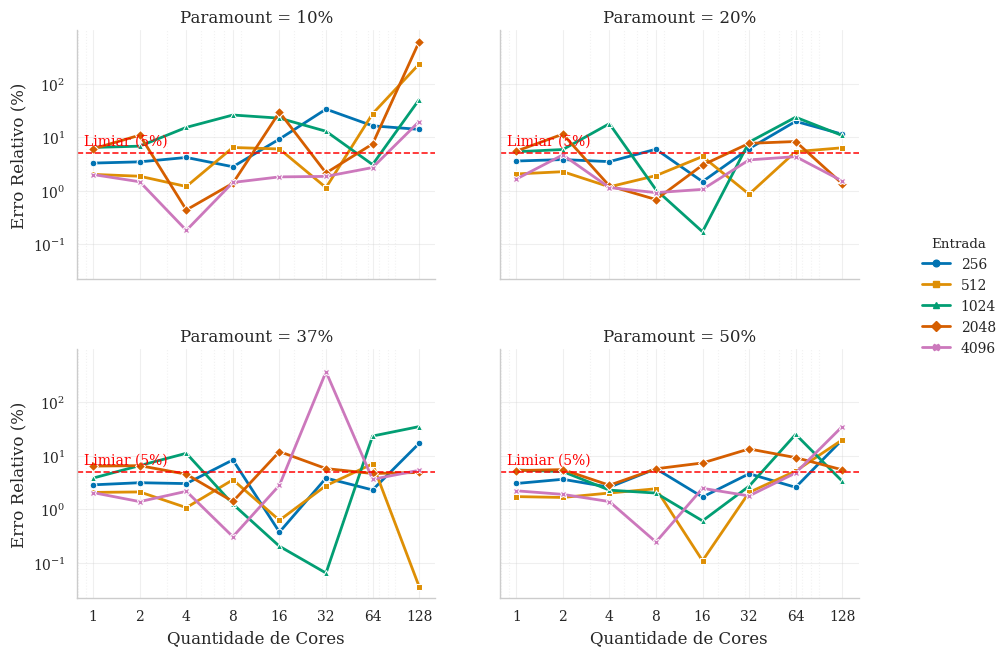

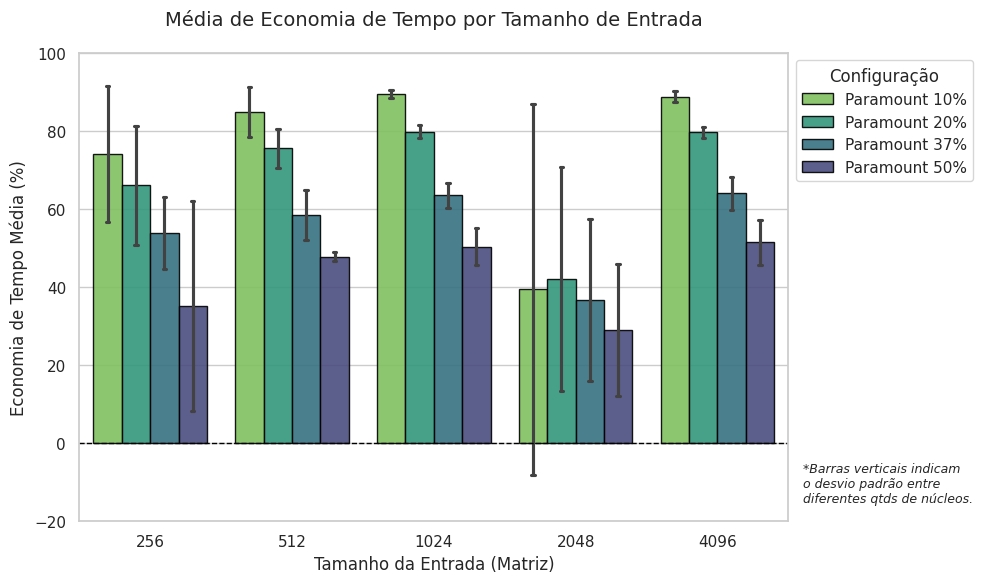

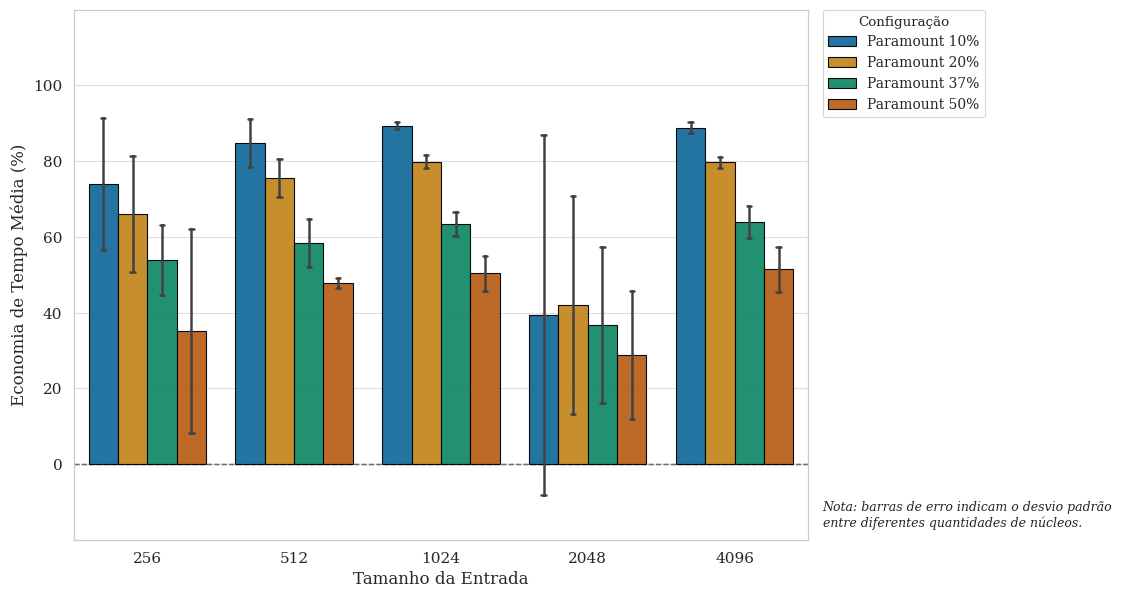

In [47]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "matrix-multiplication")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

df_gain = generate_gain_graph(app_dir, save_path=None)

APP: /home/reilta/Documents/mestrado/matrix-multiplication-afinidade
total.out: /home/reilta/Documents/mestrado/matrix-multiplication-afinidade/out/total.out
total.json: /home/reilta/Documents/mestrado/matrix-multiplication-afinidade/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 160 linhas | 4 porcentagens


/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


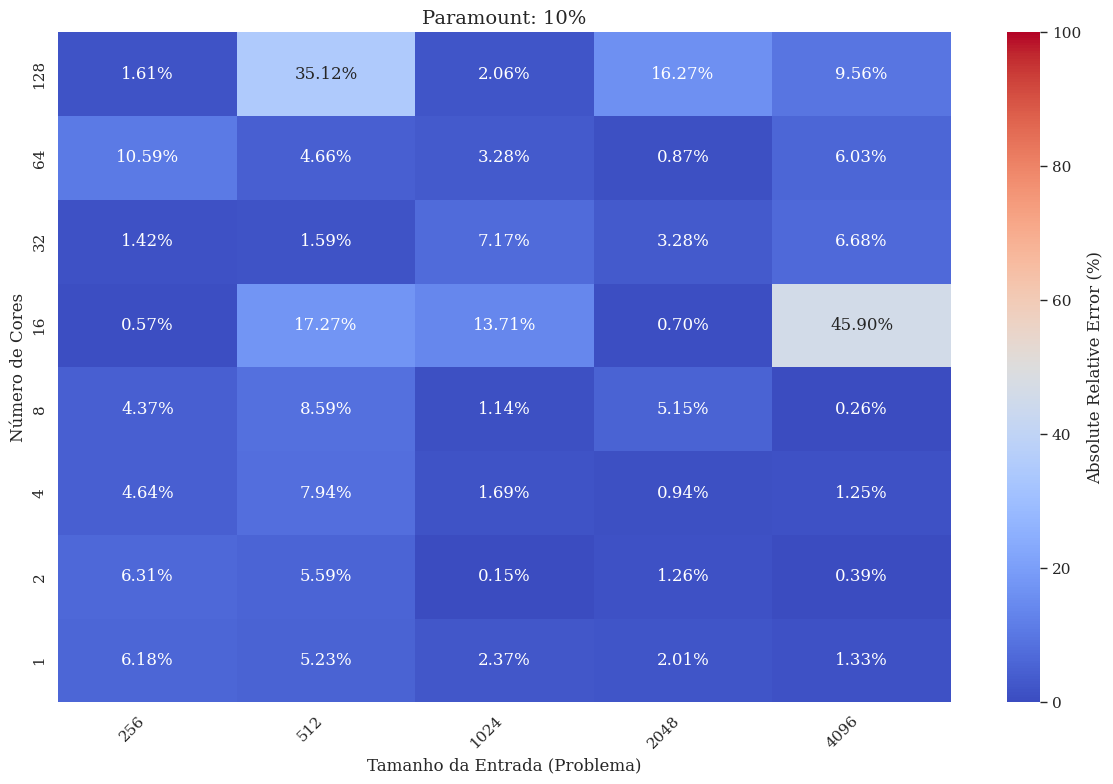

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


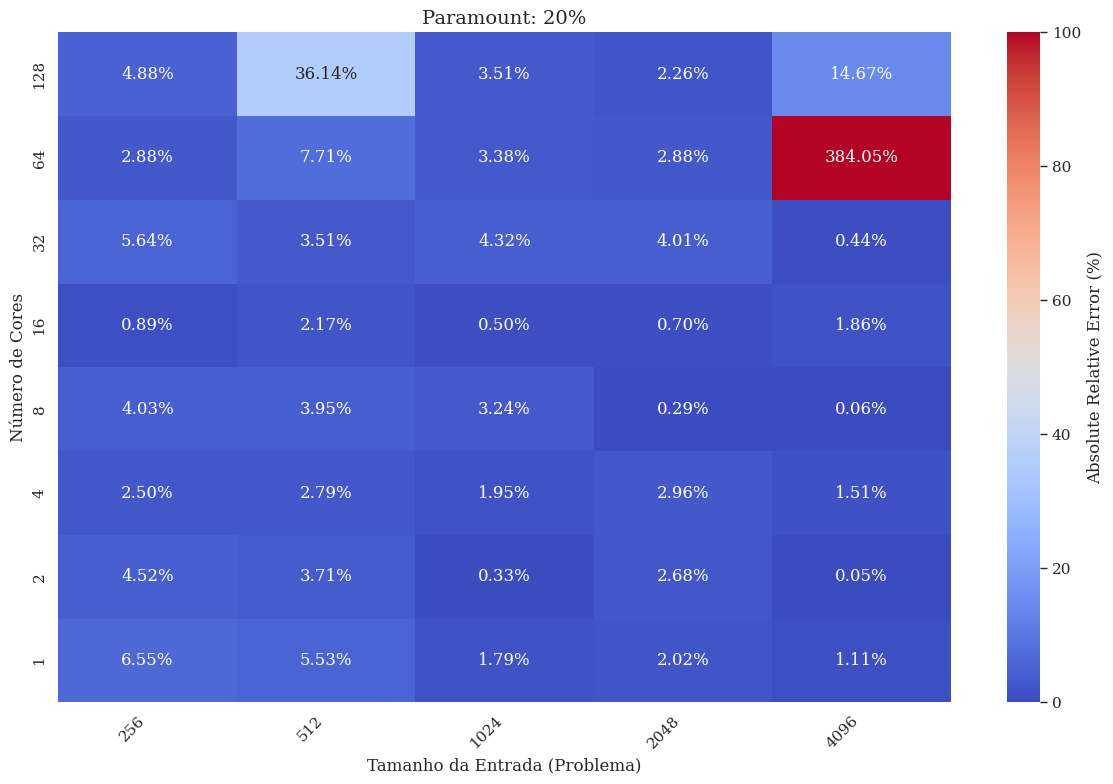

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


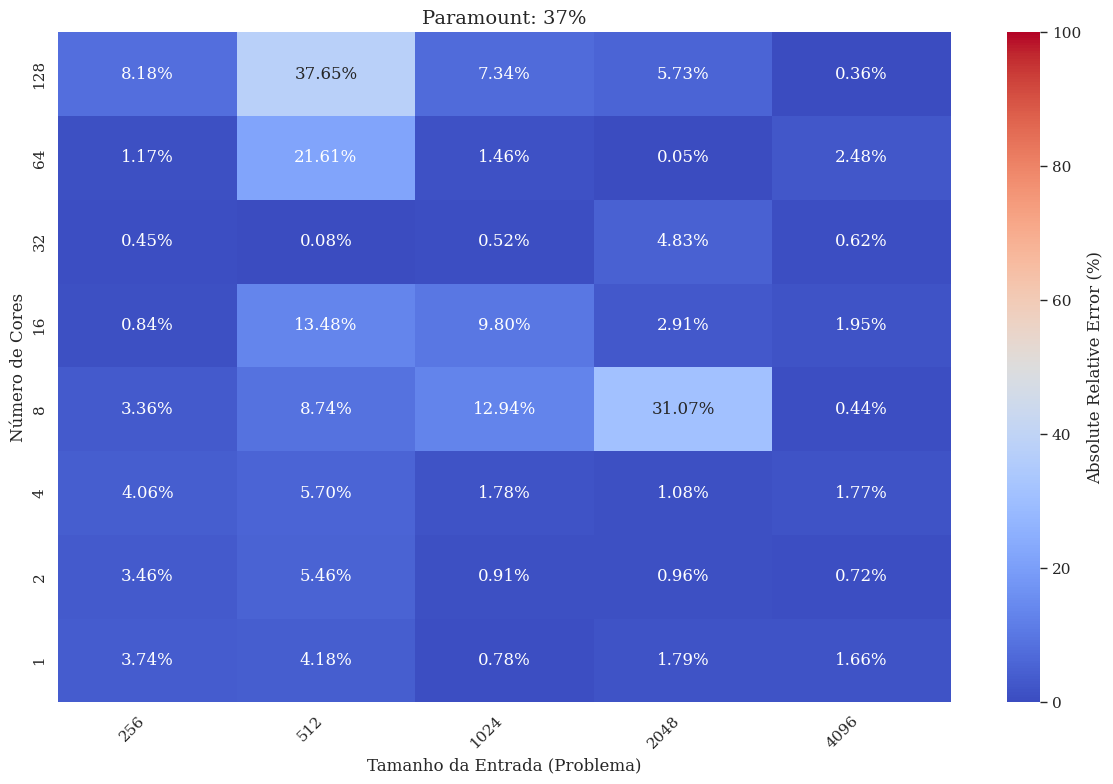

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


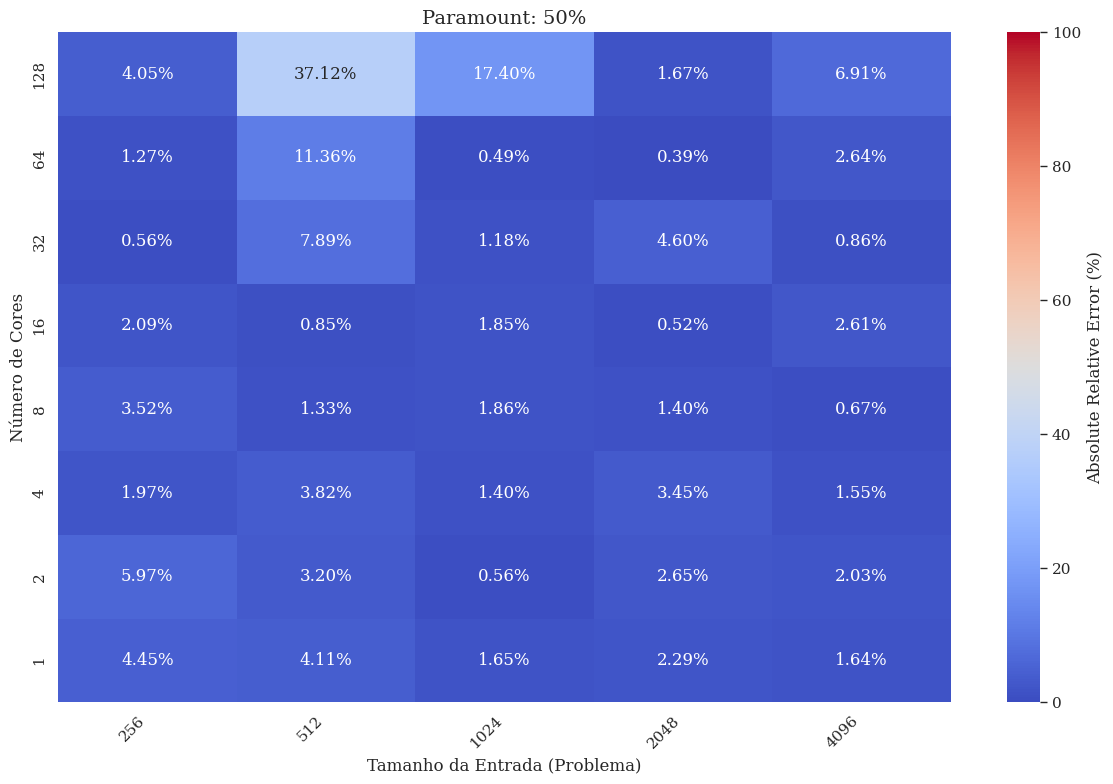

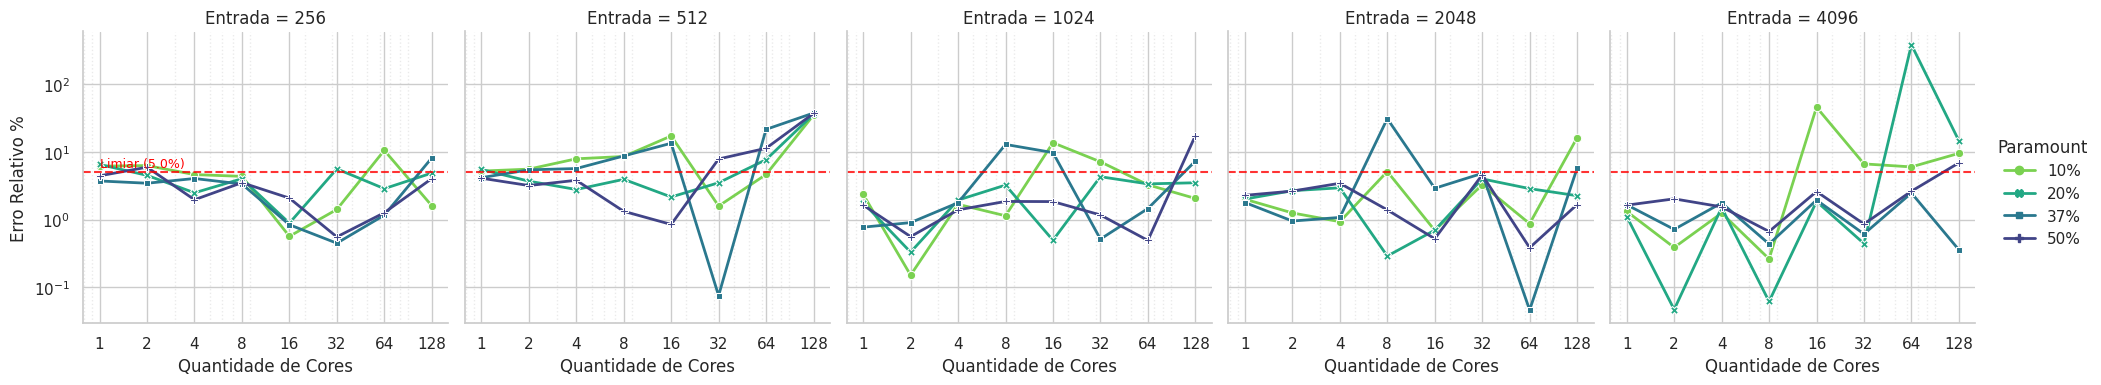

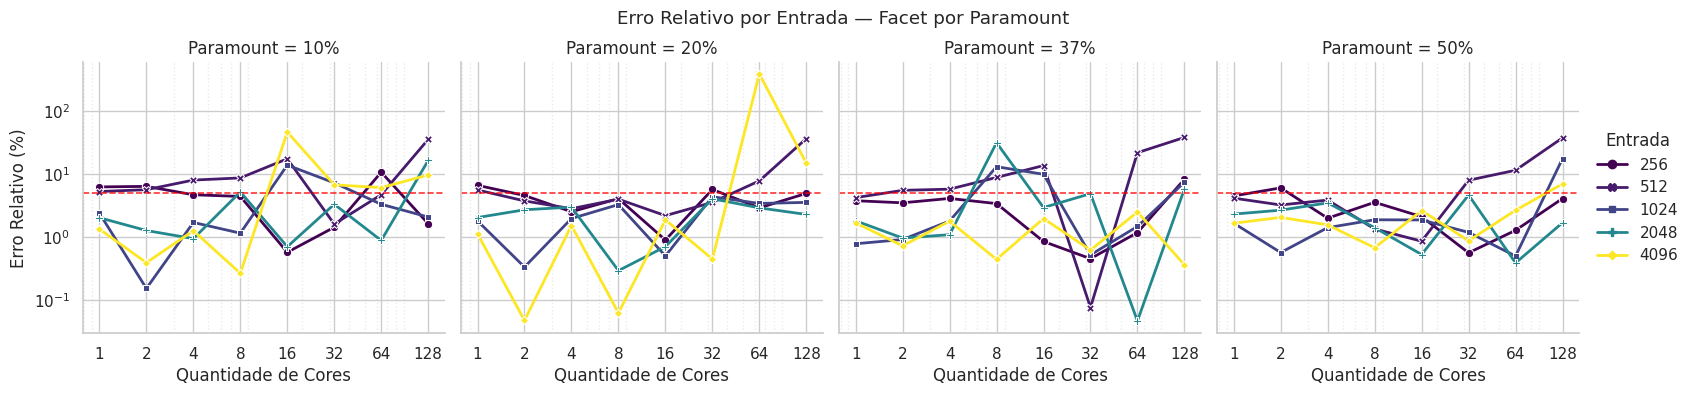

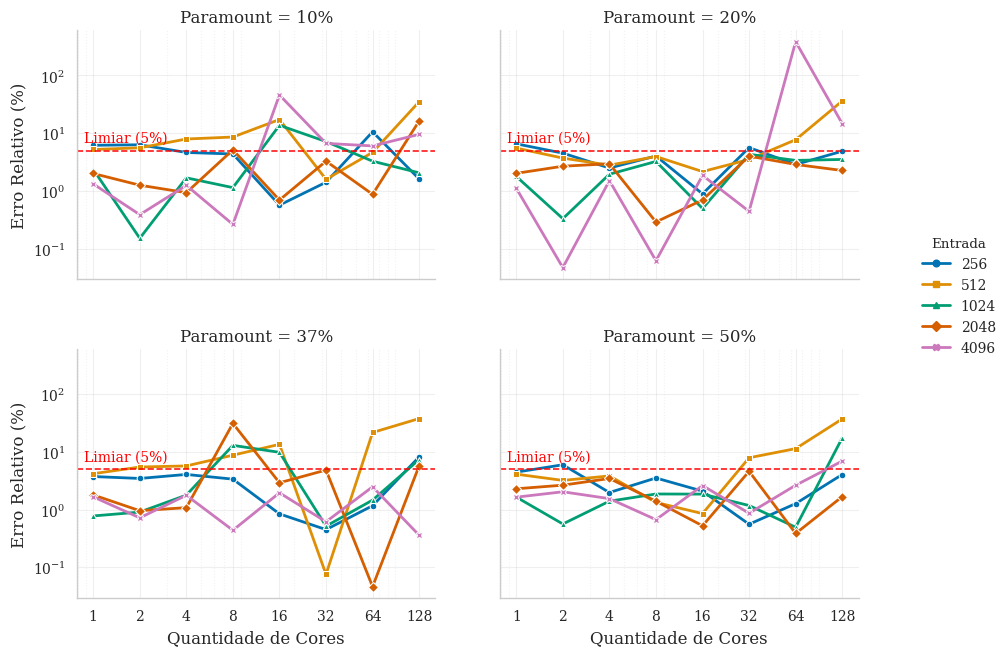

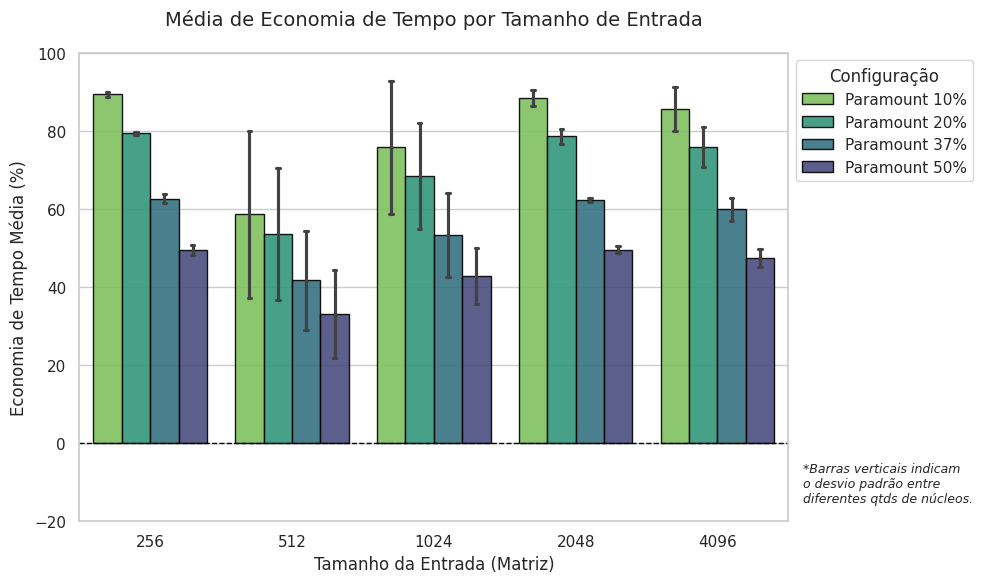

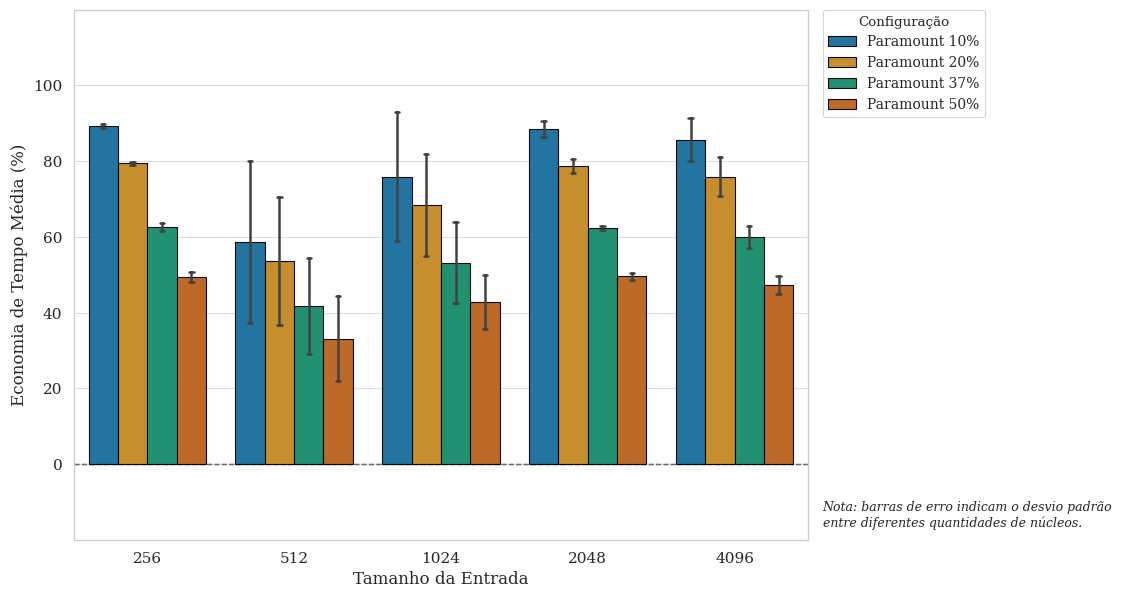

In [48]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "matrix-multiplication-afinidade")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

df_gain = generate_gain_graph(app_dir, save_path=None)

APP: /home/reilta/Documents/mestrado/multi-paramount-sscad
total.out: /home/reilta/Documents/mestrado/multi-paramount-sscad/out/total.out
total.json: /home/reilta/Documents/mestrado/multi-paramount-sscad/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 160 linhas | 4 porcentagens


/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


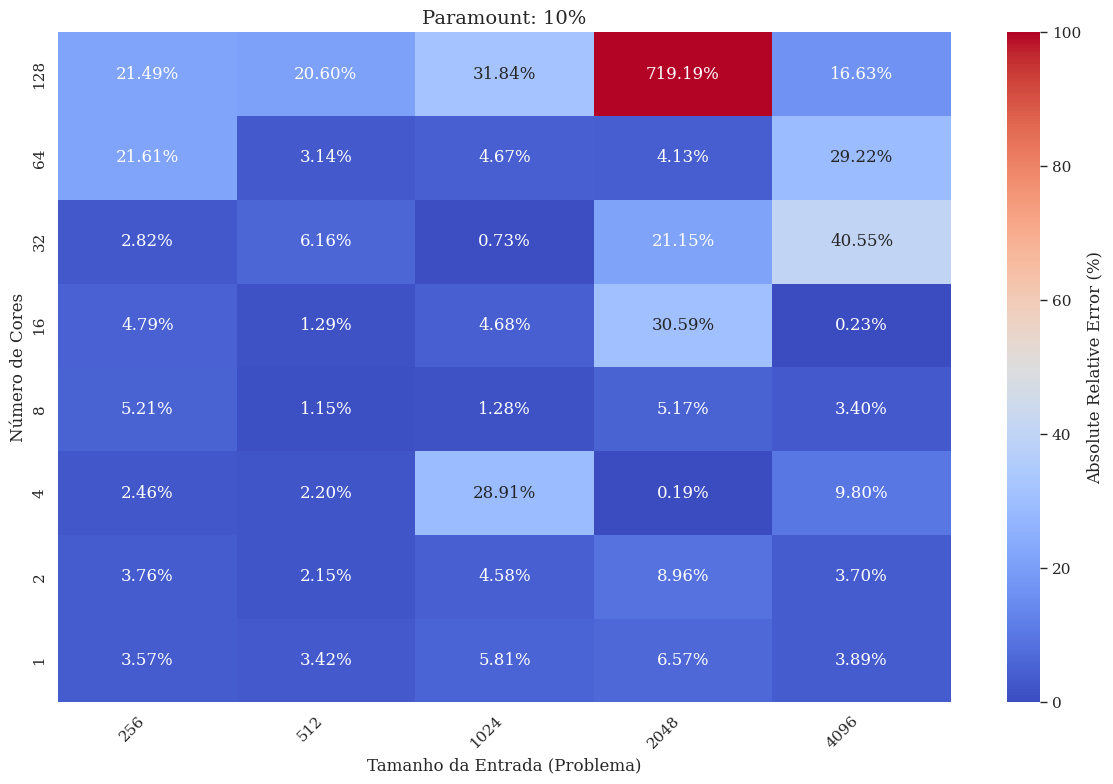

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


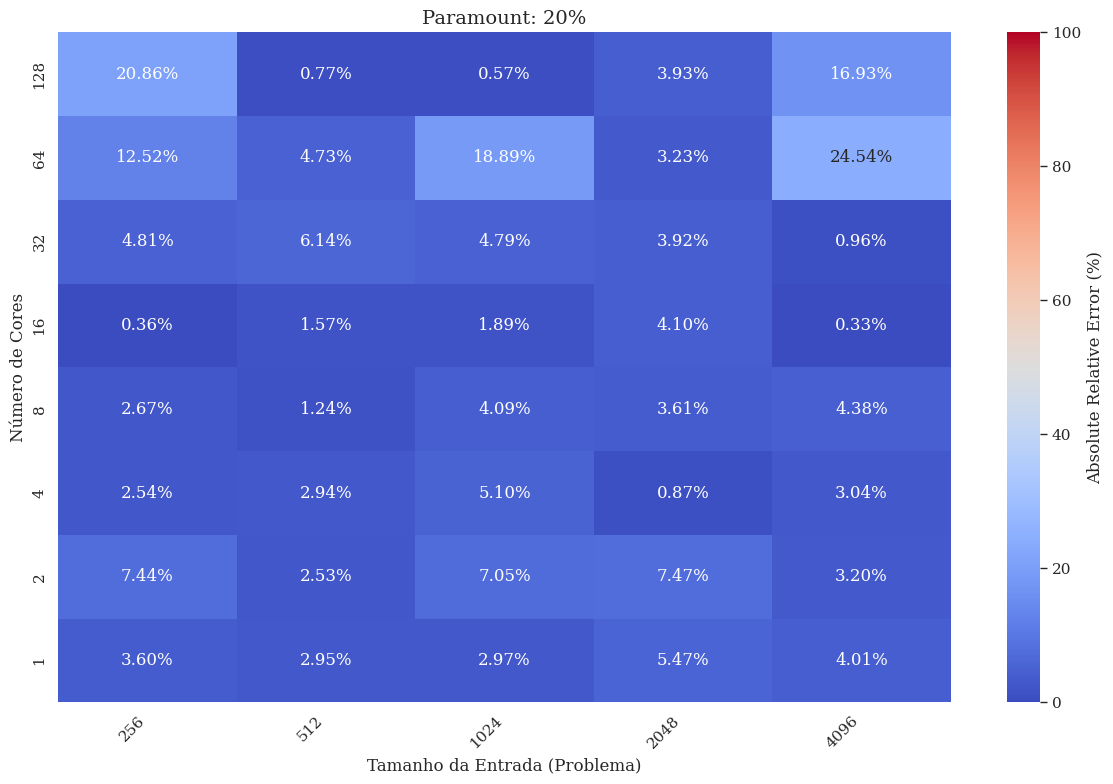

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


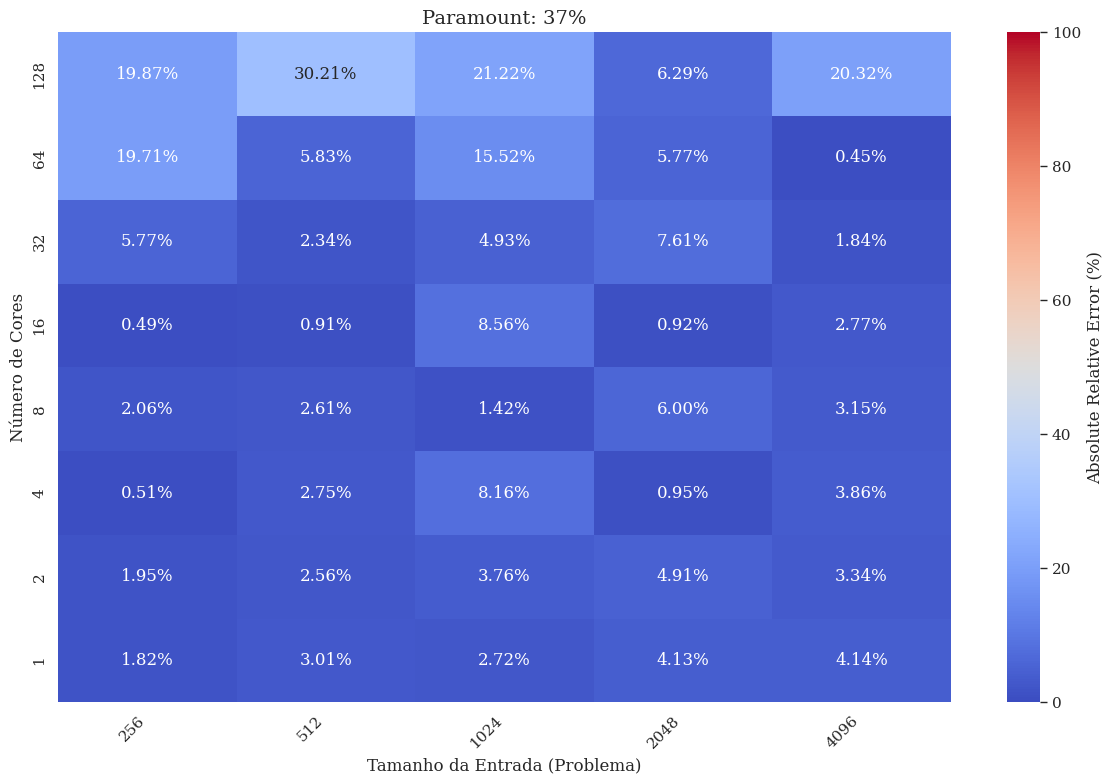

/tmp/ipykernel_71977/3903414164.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


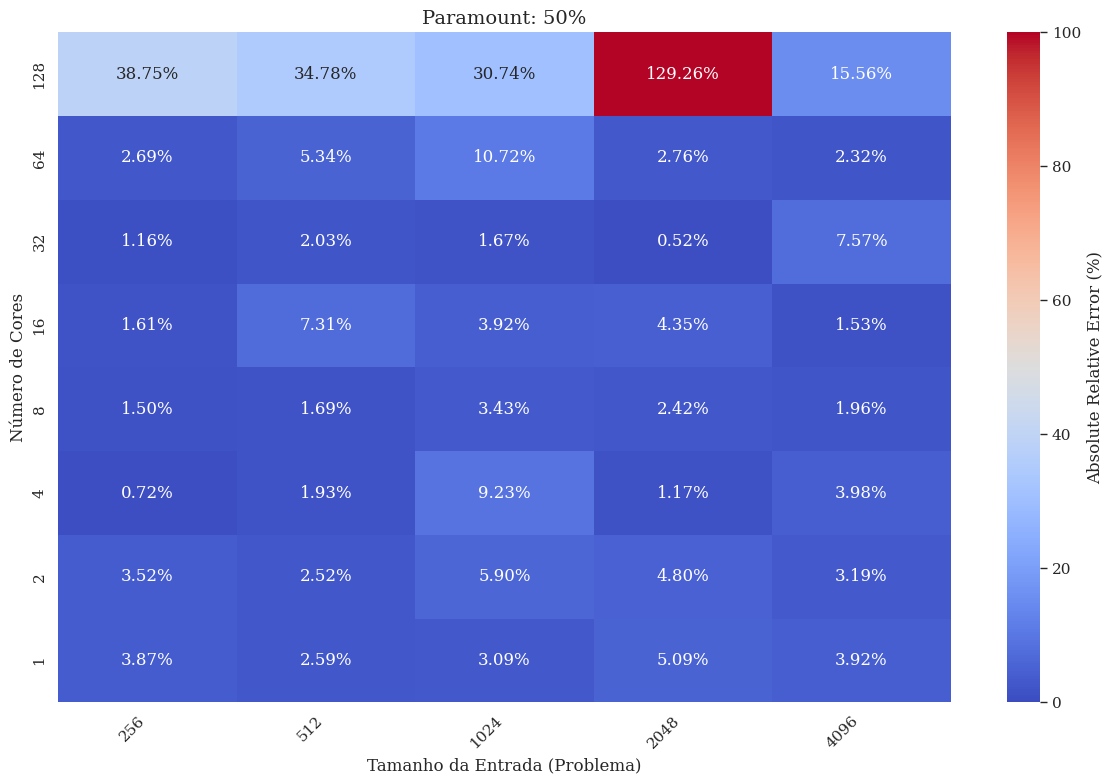

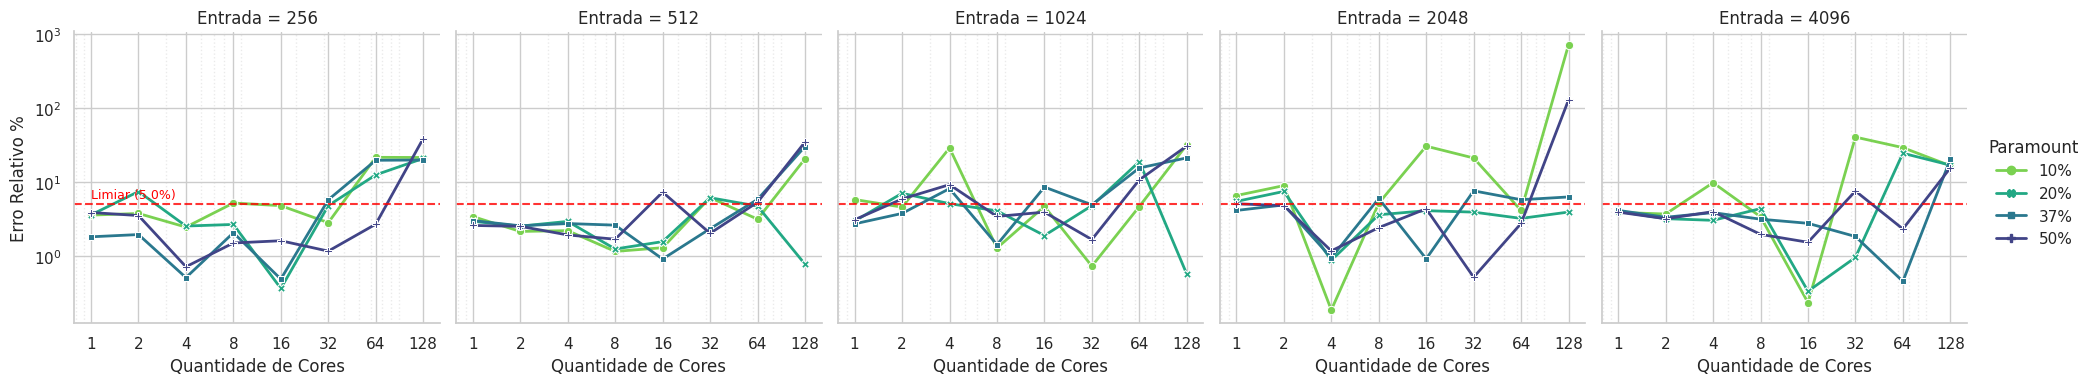

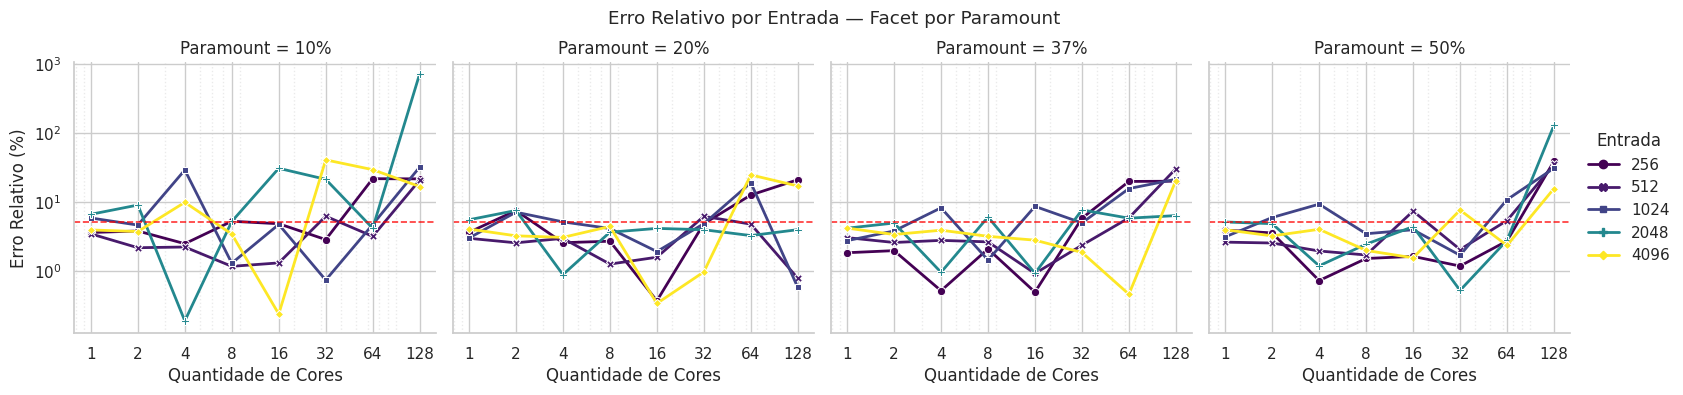

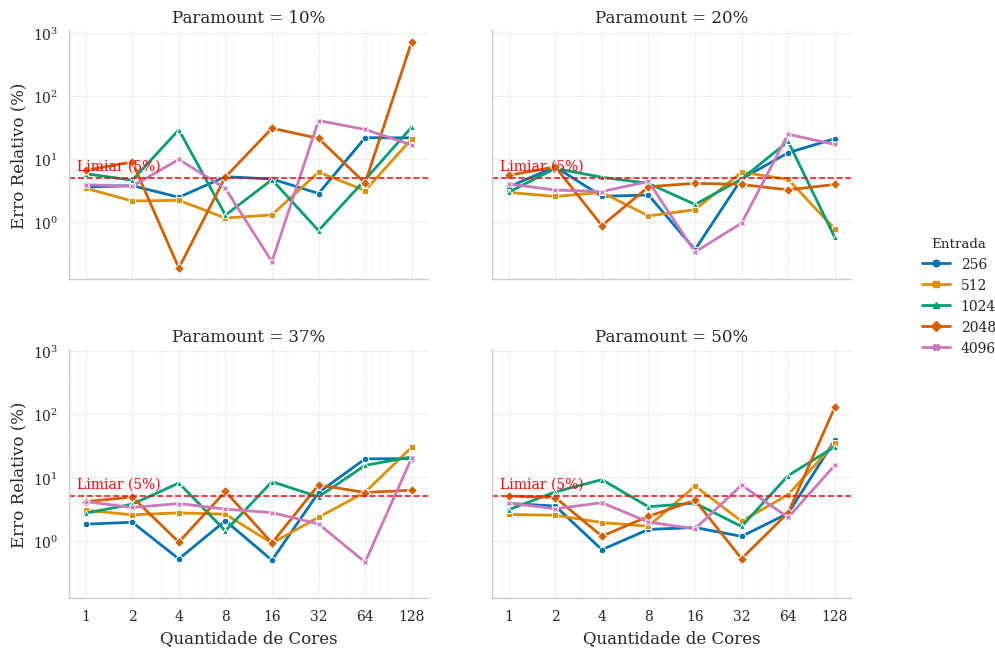

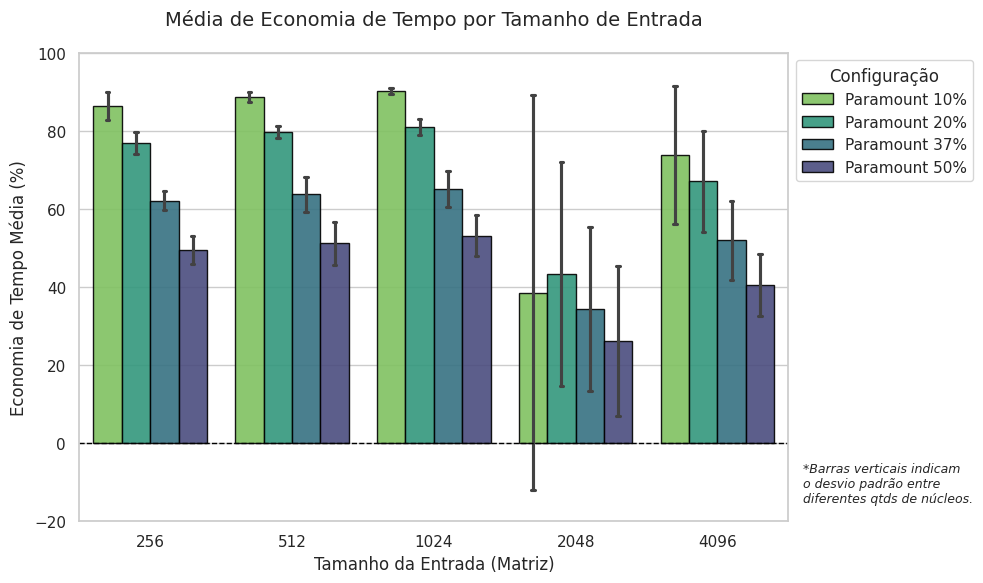

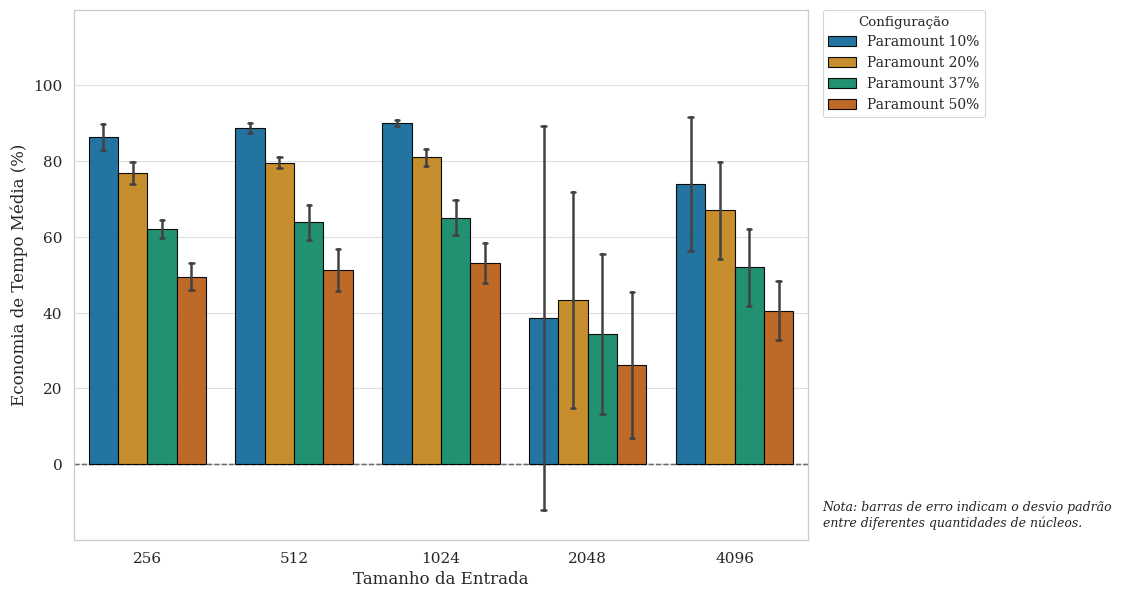

In [49]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "multi-paramount-sscad")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)

df_gain = generate_gain_graph(app_dir, save_path=None)

APP: /home/reilta/Documents/mestrado/mandelbrot-afinidade
total.out: /home/reilta/Documents/mestrado/mandelbrot-afinidade/out/total.out
total.json: /home/reilta/Documents/mestrado/mandelbrot-afinidade/total.json
parciais: ['10.json', '20.json', '37.json', '50.json']
df_errors: 128 linhas | 4 porcentagens


/tmp/ipykernel_71977/2305426348.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


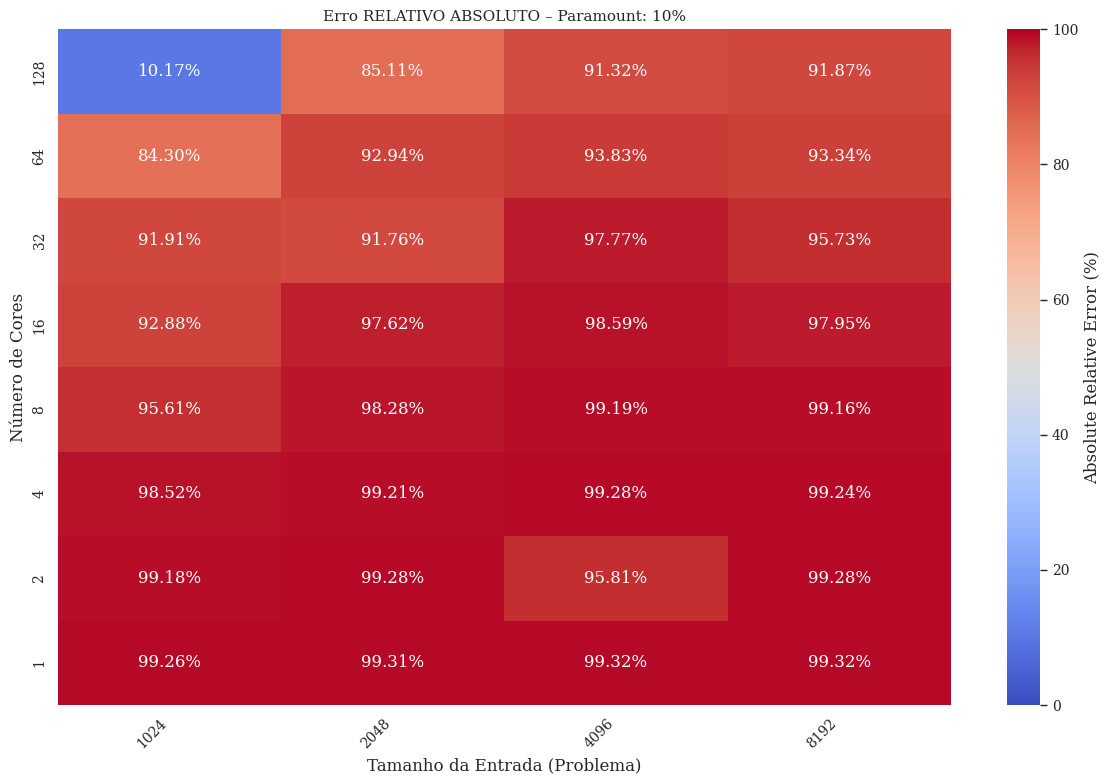

/tmp/ipykernel_71977/2305426348.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


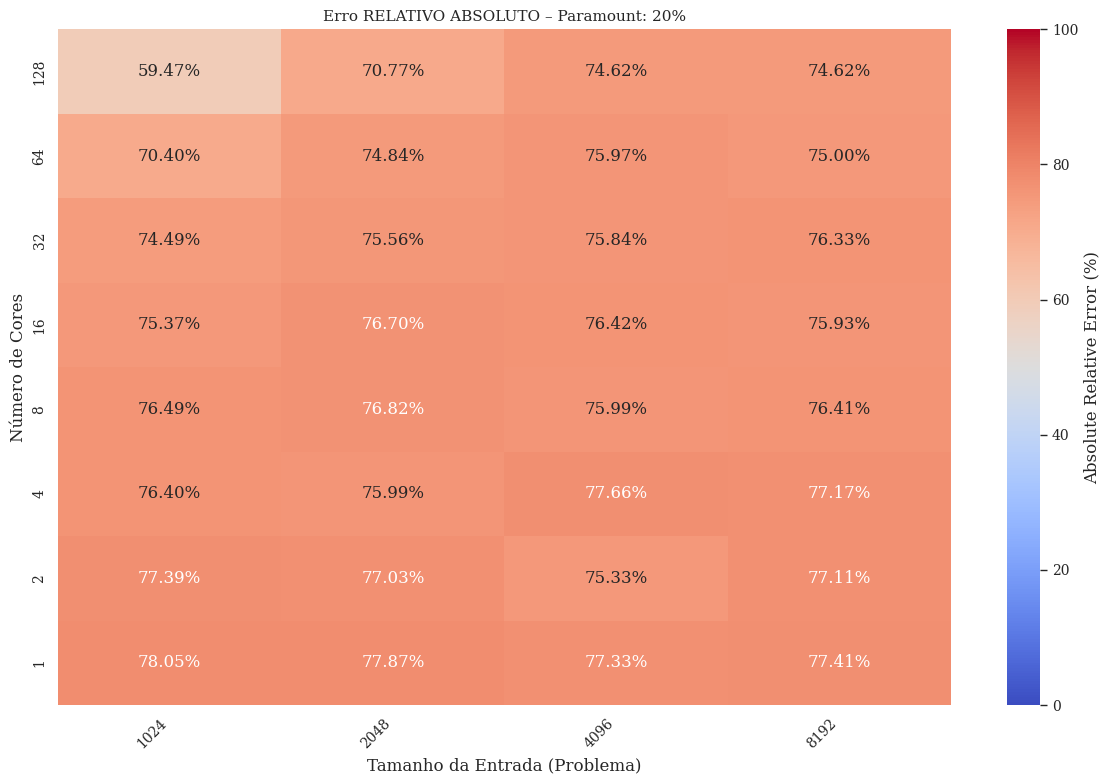

/tmp/ipykernel_71977/2305426348.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


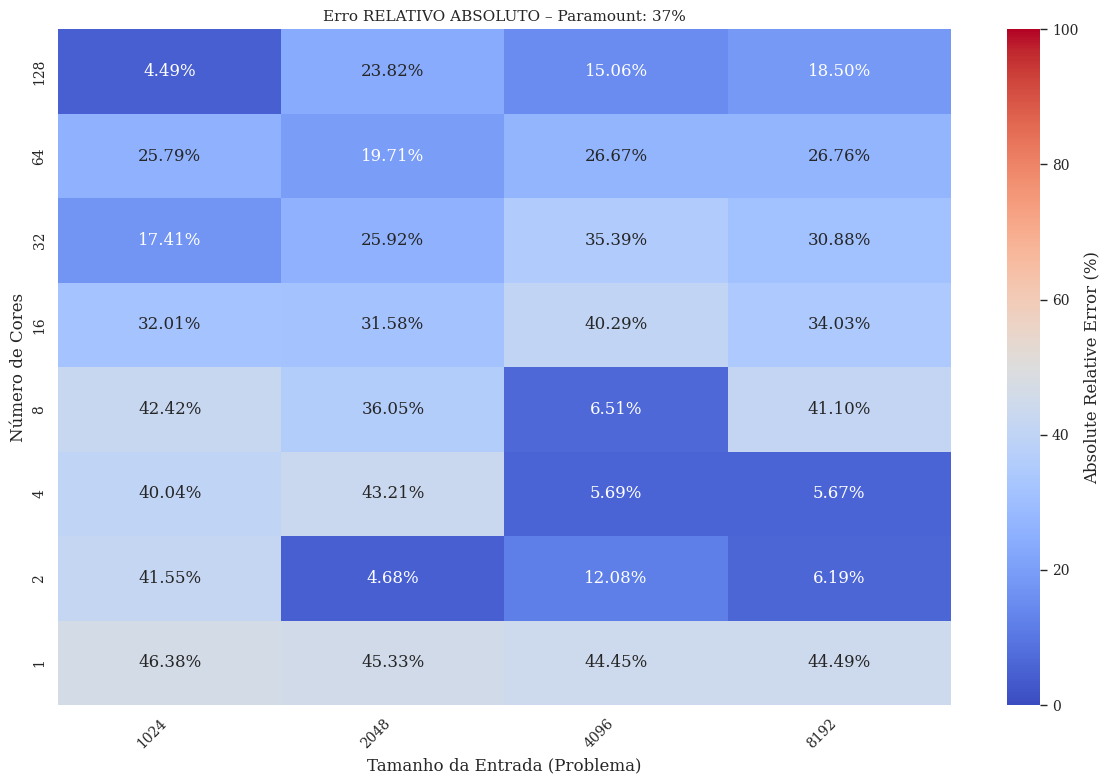

/tmp/ipykernel_71977/2305426348.py:281: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = heatmap_df.applymap(lambda x: "" if pd.isna(x) else f"{x:.2f}%")


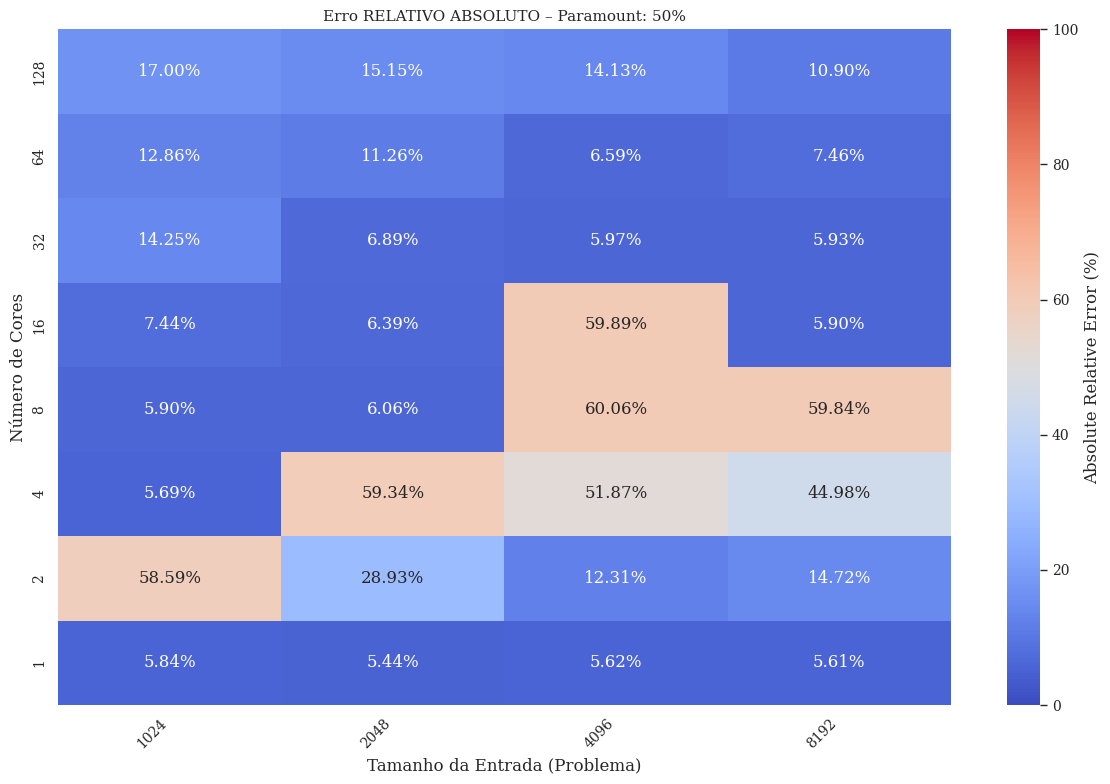

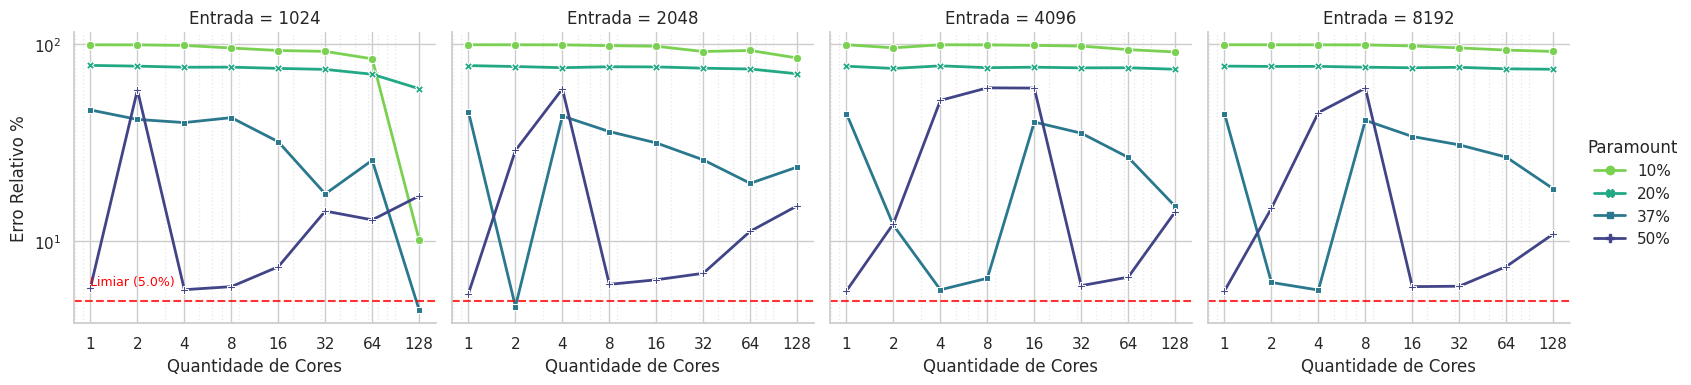

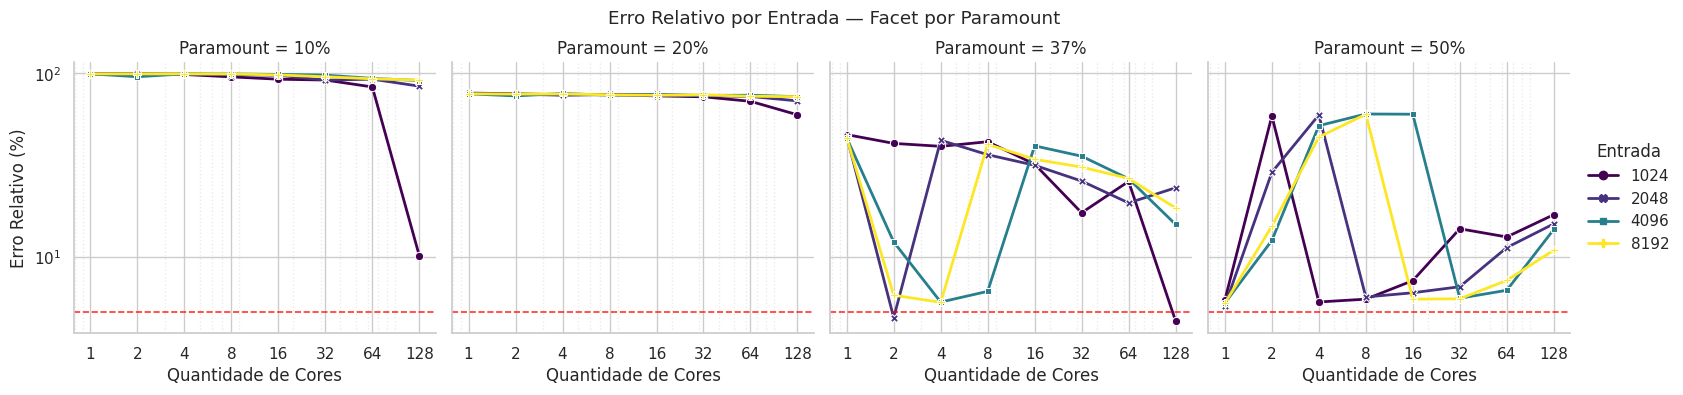

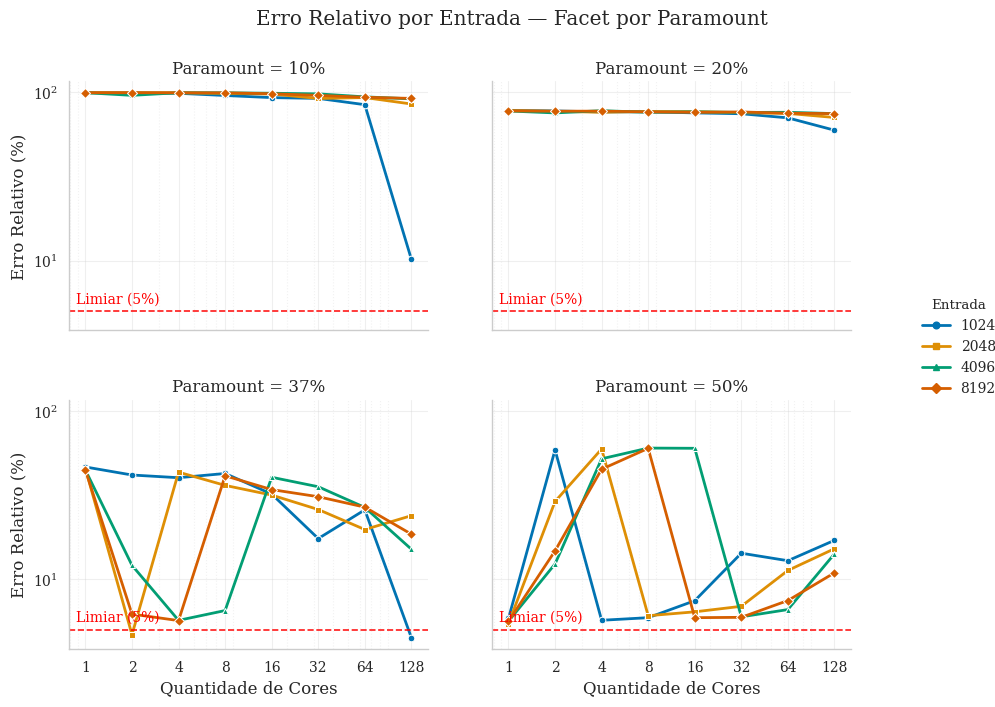

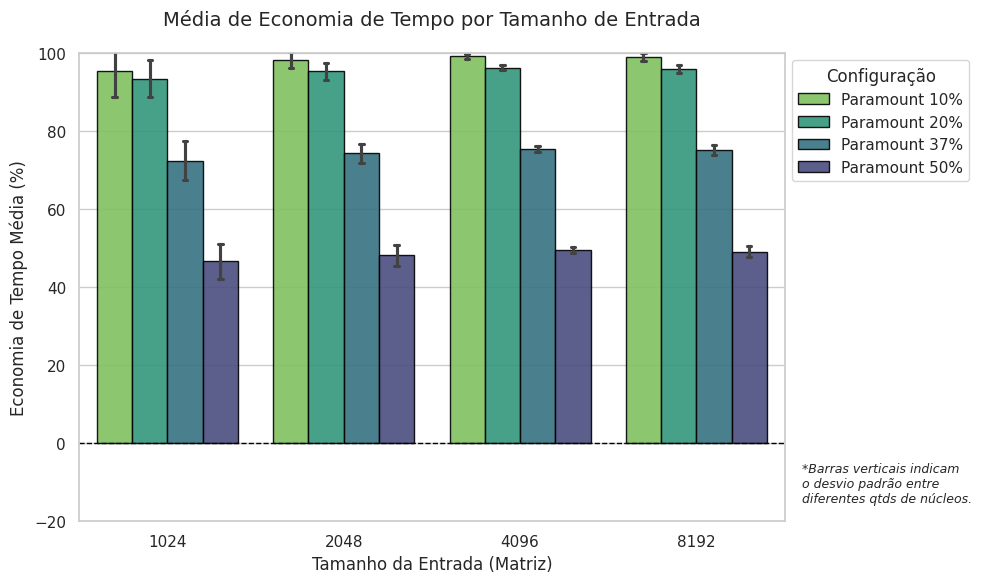

In [8]:
# Célula de execução: troque apenas o diretório da aplicação

# Exemplo 1 (seus dados atuais):
app_dir = os.path.join(os.getcwd(), "mandelbrot-afinidade")

# Exemplo 2 (quando cada aplicação estiver em uma pasta própria):
# app_dir = "/caminho/para/minha-aplicacao"

df_errors = generate_graphs(app_dir, limiar=5.0, vmax=100.0, save_prefix=None)
df_gain = generate_gain_graph(app_dir, save_path=None)

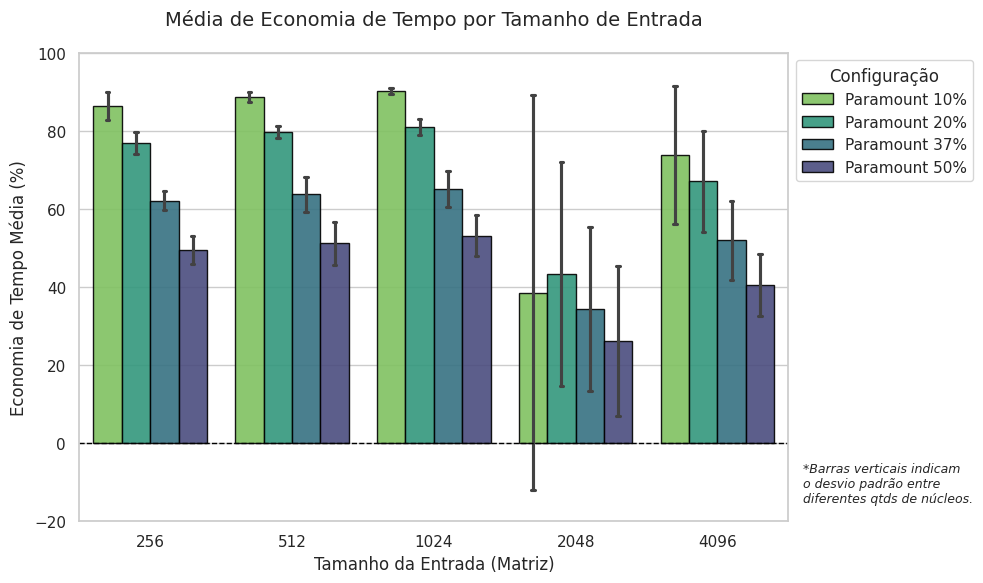

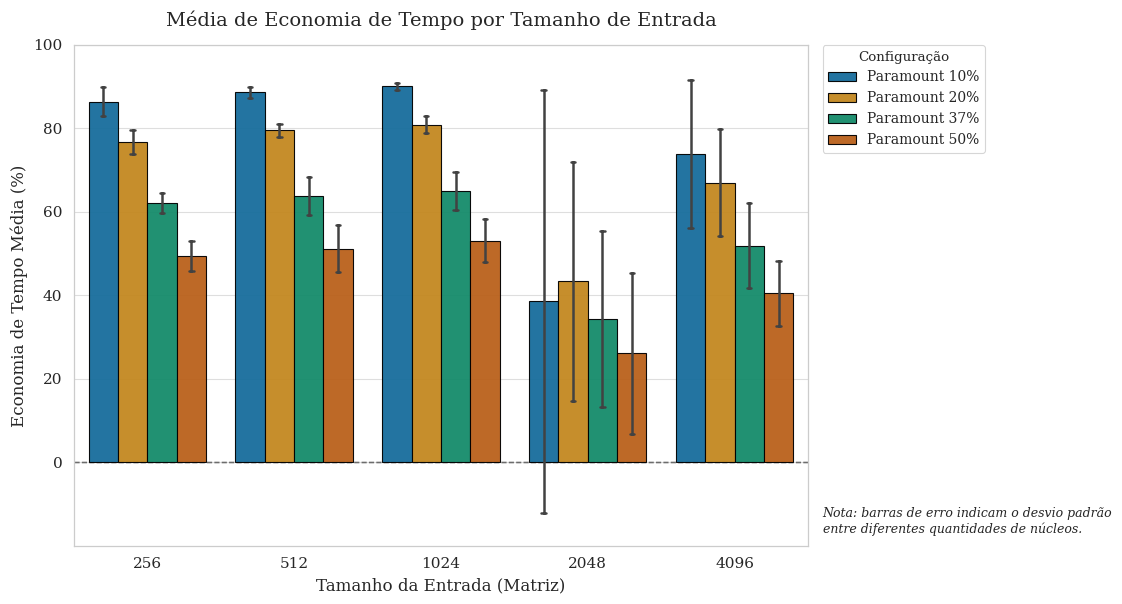

In [35]:
# (Opcional) Ganho/Economia: troque apenas o diretório da aplicação

app_dir = os.path.join(os.getcwd(), "multi-paramount-sscad")



df_gain = generate_gain_graph(app_dir, save_path=None)

In [22]:
# Validação rápida dos cálculos de economia
import pandas as pd
import numpy as np

if "df_gain" not in globals():
    raise RuntimeError("Rode a célula do ganho (df_gain = generate_gain_graph(...)) primeiro.")

# 1) Tabela agregada que o barplot está mostrando: média e desvio padrão entre núcleos
summary = (
    df_gain.dropna(subset=["Ganho (%)", "Entrada", "Núcleos"])
    .groupby(["Paramount", "Entrada"], observed=True)["Ganho (%)"]
    .agg(media="mean", desvio_padrao="std", n="count")
    .reset_index()
    .sort_values(["Paramount", "Entrada"])
 )
print("Resumo (o que o gráfico de barras representa):")
display(summary)

# 2) Checagem de fórmula em alguns pontos (recalcula a partir dos .out)
total_out_path, partial_outs = _find_gain_out_files(app_dir)
base_means = _parse_out_means(total_out_path)
print(f"Baseline usado: {total_out_path}")
print("Parciais usados:", [p for p,_ in partial_outs])

# escolhe 1 pct, 1 entrada e 3 núcleos para inspecionar
pct_label = str(df_gain["Paramount"].cat.categories[0])
entrada_val = int(sorted(df_gain["Entrada"].dropna().unique())[0])
cores_sample = sorted(df_gain["Núcleos"].dropna().unique(), reverse=True)[:3]

# mapeia Entrada -> input_idx via total.json
total_json_path = _find_total_json(app_dir)
with open(total_json_path, "r") as f:
    total_data = json.load(f)
arguments = total_data.get("config", {}).get("arguments", [])
arg_labels = [os.path.basename(a) for a in arguments]
idx_by_entrada = {extract_first_number(lbl): i for i, lbl in enumerate(arg_labels)}
input_idx = idx_by_entrada.get(entrada_val)
if input_idx is None:
    raise RuntimeError(f"Não consegui mapear Entrada={entrada_val} para input_idx via {total_json_path}")

pct_out_path = None
for p, lbl in partial_outs:
    if lbl == pct_label:
        pct_out_path = p
        break
if pct_out_path is None:
    raise RuntimeError(f"Não achei .out correspondente ao {pct_label}")

pct_means = _parse_out_means(pct_out_path)
print(f"Exemplo de checagem: {pct_label} | Entrada={entrada_val} (input_idx={input_idx})")
for ncores in cores_sample:
    t_total = base_means.get((int(ncores), input_idx), np.nan)
    t_pct = pct_means.get((int(ncores), input_idx), np.nan)
    gain_calc = (1.0 - (t_pct / t_total)) * 100.0 if (not pd.isna(t_total) and t_total > 0 and not pd.isna(t_pct)) else np.nan
    gain_df = df_gain[(df_gain["Paramount"] == pct_label) & (df_gain["Entrada"] == entrada_val) & (df_gain["Núcleos"] == int(ncores))]["Ganho (%)"]
    gain_df = float(gain_df.iloc[0]) if len(gain_df) else np.nan
    print(f"  cores={int(ncores)} | T_total={t_total:.6f} | T_pct={t_pct:.6f} | ganho_calc={gain_calc:.2f}% | ganho_df={gain_df:.2f}%")

Resumo (o que o gráfico de barras representa):


Paramount  Entrada      media  desvio_padrao  n
0   Paramount 10%      256  86.367909       3.487473  8
1   Paramount 10%      512  88.672731       1.322353  8
2   Paramount 10%     1024  90.107527       0.794242  8
3   Paramount 10%     2048  38.566381      50.576104  8
4   Paramount 10%     4096  73.859559      17.708463  8
5   Paramount 20%      256  76.821920       2.853425  8
6   Paramount 20%      512  79.596101       1.546741  8
7   Paramount 20%     1024  80.940337       2.123169  8
8   Paramount 20%     2048  43.337020      28.592582  8
9   Paramount 20%     4096  67.035332      12.834030  8
10  Paramount 37%      256  62.143998       2.338667  8
11  Paramount 37%      512  63.786476       4.513836  8
12  Paramount 37%     1024  65.031466       4.570690  8
13  Paramount 37%     2048  34.371920      21.023671  8
14  Paramount 37%     4096  51.916662      10.152376  8
15  Paramount 50%      256  49.487499       3.568436  8
16  Paramount 50%      512  51.184822       5.592902  8
17  Paramount 50%     1024  53.134566       5.199988  8
18  Paramount 50%     2048  26.118342      19.267699  8
19  Paramount 50%     4096  40.518457       7.845509  8

Baseline usado: /Users/igorsergio/Documents/Geral/Mestrado - Reilta/multi-paramount/out/total.out
Parciais usados: ['/Users/igorsergio/Documents/Geral/Mestrado - Reilta/multi-paramount/out/10.out', '/Users/igorsergio/Documents/Geral/Mestrado - Reilta/multi-paramount/out/20.out', '/Users/igorsergio/Documents/Geral/Mestrado - Reilta/multi-paramount/out/37.out', '/Users/igorsergio/Documents/Geral/Mestrado - Reilta/multi-paramount/out/50.out']
Exemplo de checagem: Paramount 10% | Entrada=256 (input_idx=2)
  cores=128 | T_total=0.229486 | T_pct=0.043271 | ganho_calc=81.14% | ganho_df=81.14%
  cores=64 | T_total=0.254156 | T_pct=0.047259 | ganho_calc=81.41% | ganho_df=81.41%
  cores=32 | T_total=0.451990 | T_pct=0.067517 | ganho_calc=85.06% | ganho_df=85.06%
